# ⚡️ Energy-Based Models

In this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

The code is adapted from the excellent ['Deep Energy-Based Generative Models' tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html) created by Phillip Lippe.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))
from notebooks.utils import display, sample_batch
import random

## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

In [3]:
# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

In [4]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [5]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

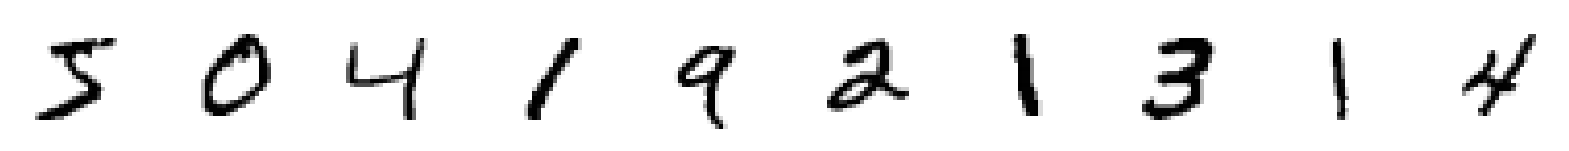

In [6]:
# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)

## 2. Build the EBM network <a name="train"></a>

In [7]:
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

In [8]:
if LOAD_MODEL:
    model.load_weights("./models/model.h5")

## 2. Set up a Langevin sampler function <a name="sampler"></a>

In [9]:
# Function to generate samples using Langevin Dynamics
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

## 3. Set up a buffer to store examples <a name="buffer"></a>

In [10]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        )
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

In [11]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [12]:
ebm = EBM()

## 3. Train the EBM network <a name="train"></a>

In [13]:
# Compile and train the model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

In [14]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="./output/example_img_%03d.png" % (epoch)
        )


image_generator_callback = ImageGenerator(num_img=10)

In [15]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("./models/model.h5")


save_model_callback = SaveModel()

Epoch 1/60
469/469 [==============================] - ETA: 0s - loss: -0.0368 - reg: 0.0129 - cdiv: -0.0497 - real: 0.2047 - fake: 0.1549      
Saved to ./output/generated_img_000.png


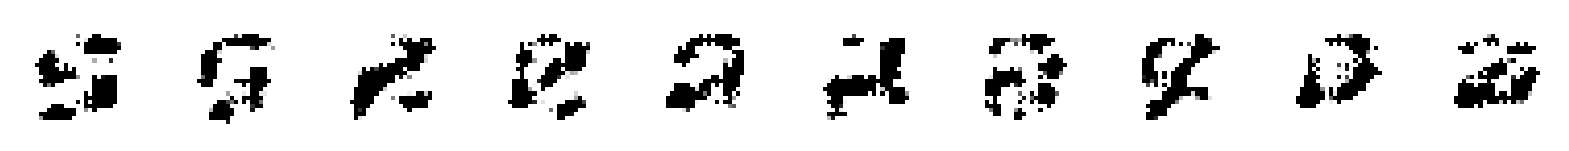


Saved to ./output/example_img_000.png


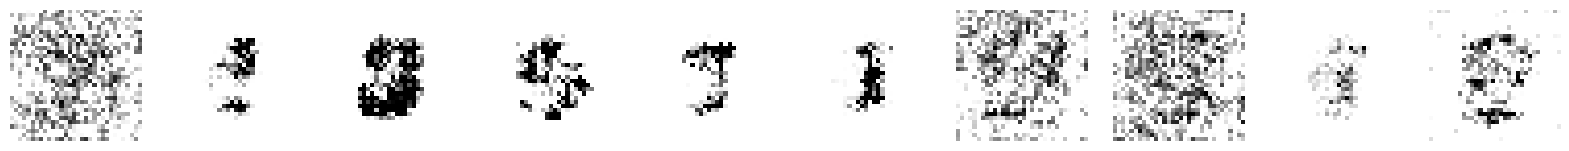

469/469 [==============================] - 433s 909ms/step - loss: -0.0368 - reg: 0.0129 - cdiv: -0.0497 - real: 0.2047 - fake: 0.1549 - val_cdiv: -1.5131 - val_real: -0.0567 - val_fake: -1.5698
Epoch 2/60
469/469 [==============================] - ETA: 0s - loss: -0.0018 - reg: 0.0017 - cdiv: -0.0036 - real: 0.0078 - fake: 0.0042       
Saved to ./output/generated_img_001.png


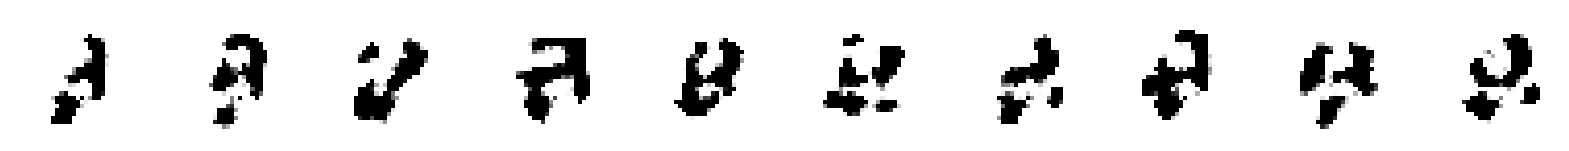


Saved to ./output/example_img_001.png


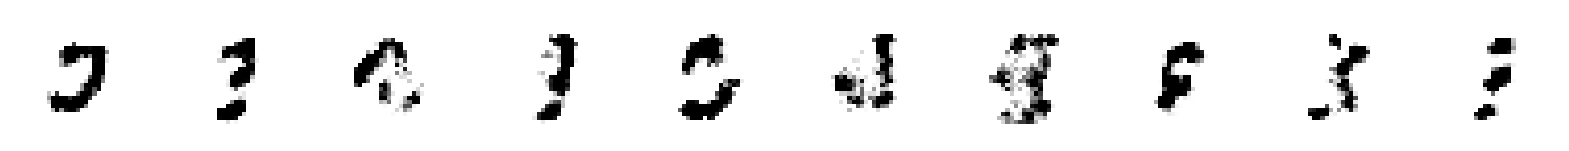

469/469 [==============================] - 472s 1s/step - loss: -0.0018 - reg: 0.0017 - cdiv: -0.0036 - real: 0.0078 - fake: 0.0042 - val_cdiv: -1.7291 - val_real: -0.0765 - val_fake: -1.8056
Epoch 3/60
469/469 [==============================] - ETA: 0s - loss: -0.0011 - reg: 0.0011 - cdiv: -0.0022 - real: 0.0033 - fake: 0.0011       
Saved to ./output/generated_img_002.png


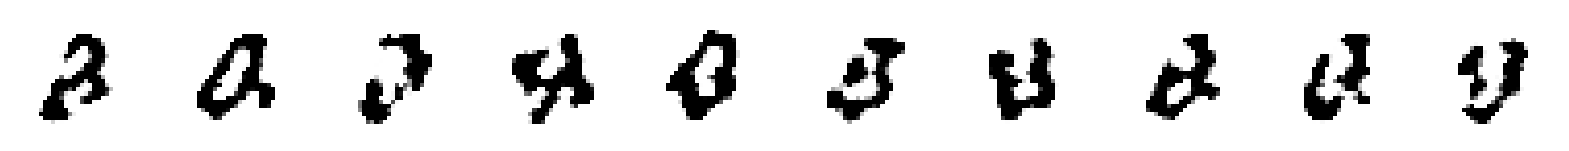


Saved to ./output/example_img_002.png


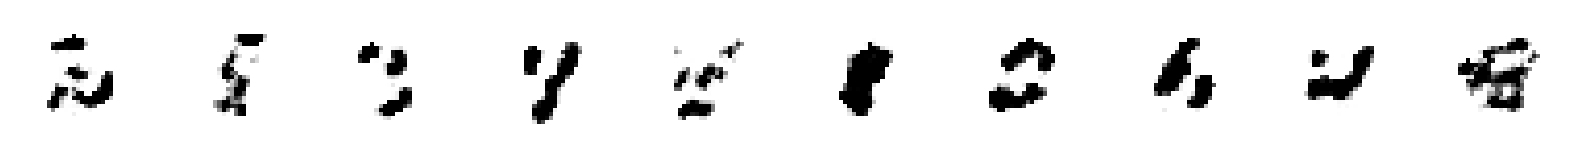

469/469 [==============================] - 505s 1s/step - loss: -0.0011 - reg: 0.0011 - cdiv: -0.0022 - real: 0.0033 - fake: 0.0011 - val_cdiv: -2.0173 - val_real: -0.0367 - val_fake: -2.0540
Epoch 4/60
469/469 [==============================] - ETA: 0s - loss: 1.9681e-04 - reg: 6.0804e-04 - cdiv: -4.1123e-04 - real: 0.0020 - fake: 0.0016        
Saved to ./output/generated_img_003.png


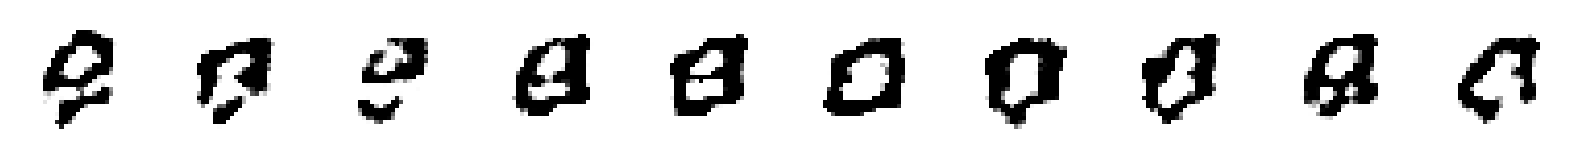


Saved to ./output/example_img_003.png


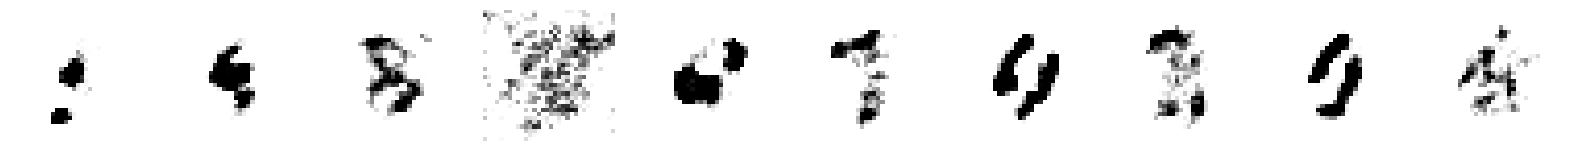

469/469 [==============================] - 521s 1s/step - loss: 1.9681e-04 - reg: 6.0804e-04 - cdiv: -4.1123e-04 - real: 0.0020 - fake: 0.0016 - val_cdiv: -2.2075 - val_real: -0.0351 - val_fake: -2.2426
Epoch 5/60
469/469 [==============================] - ETA: 0s - loss: 3.6542e-04 - reg: 3.7711e-04 - cdiv: -1.1688e-05 - real: 0.0016 - fake: 0.0016           
Saved to ./output/generated_img_004.png


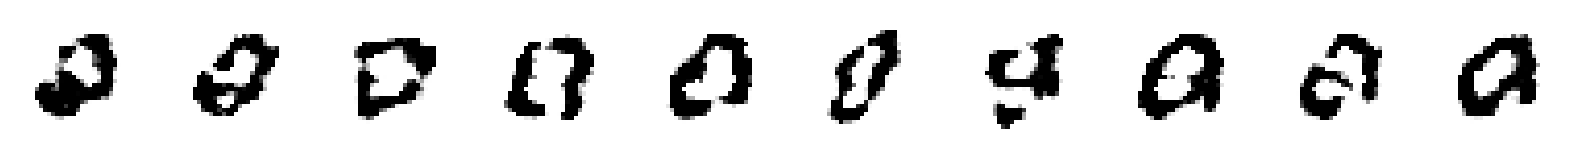


Saved to ./output/example_img_004.png


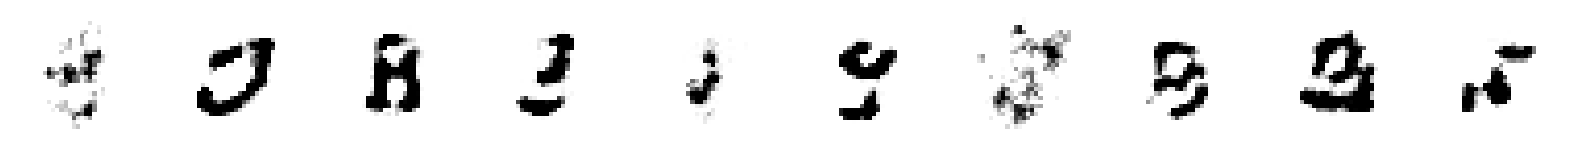

469/469 [==============================] - 492s 1s/step - loss: 3.6542e-04 - reg: 3.7711e-04 - cdiv: -1.1688e-05 - real: 0.0016 - fake: 0.0016 - val_cdiv: -2.4345 - val_real: -0.0218 - val_fake: -2.4562
Epoch 6/60
469/469 [==============================] - ETA: 0s - loss: 4.7077e-04 - reg: 2.6342e-04 - cdiv: 2.0736e-04 - real: 0.0014 - fake: 0.0016              
Saved to ./output/generated_img_005.png


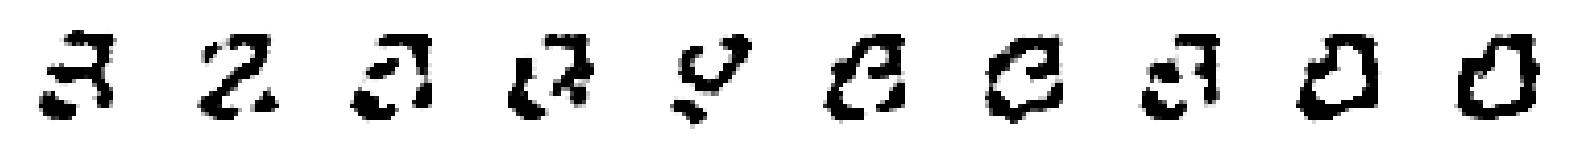


Saved to ./output/example_img_005.png


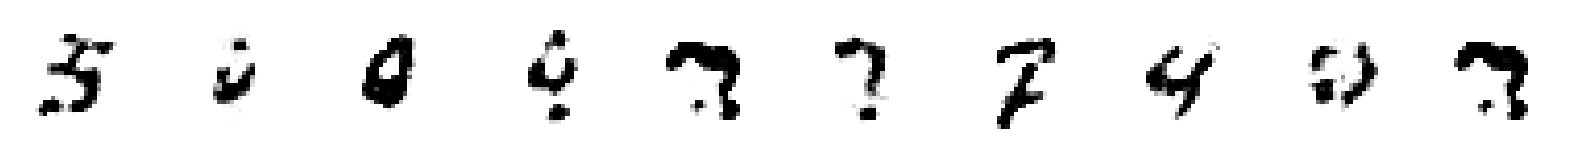

469/469 [==============================] - 490s 1s/step - loss: 4.7077e-04 - reg: 2.6342e-04 - cdiv: 2.0736e-04 - real: 0.0014 - fake: 0.0016 - val_cdiv: -2.6888 - val_real: -0.0162 - val_fake: -2.7050
Epoch 7/60
469/469 [==============================] - ETA: 0s - loss: 2.0620e-04 - reg: 2.3592e-04 - cdiv: -2.9712e-05 - real: 0.0013 - fake: 0.0013            
Saved to ./output/generated_img_006.png


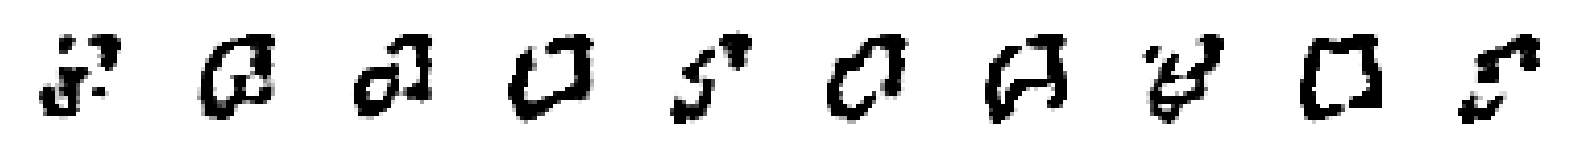


Saved to ./output/example_img_006.png


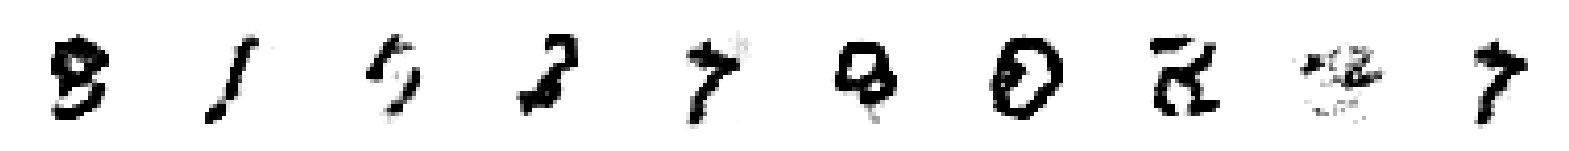

469/469 [==============================] - 455s 971ms/step - loss: 2.0620e-04 - reg: 2.3592e-04 - cdiv: -2.9712e-05 - real: 0.0013 - fake: 0.0013 - val_cdiv: -3.0679 - val_real: -0.0021 - val_fake: -3.0699
Epoch 8/60
469/469 [==============================] - ETA: 0s - loss: 6.2222e-04 - reg: 2.4029e-04 - cdiv: 3.8193e-04 - real: 9.4490e-04 - fake: 0.0013        
Saved to ./output/generated_img_007.png


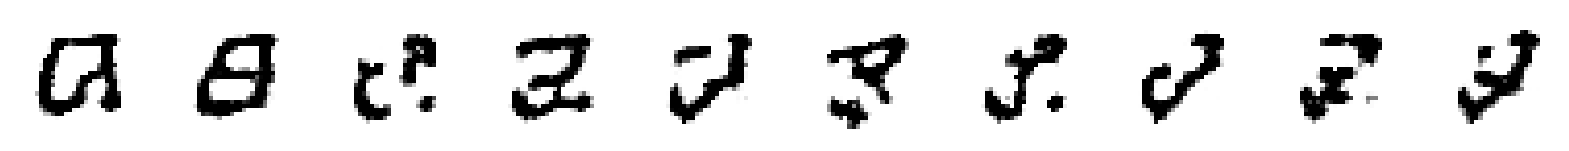


Saved to ./output/example_img_007.png


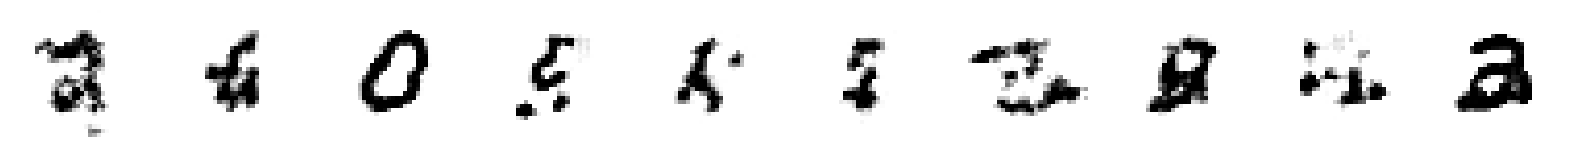

469/469 [==============================] - 487s 1s/step - loss: 6.2222e-04 - reg: 2.4029e-04 - cdiv: 3.8193e-04 - real: 9.4490e-04 - fake: 0.0013 - val_cdiv: -3.2351 - val_real: -0.0242 - val_fake: -3.2593
Epoch 9/60
469/469 [==============================] - ETA: 0s - loss: 6.2828e-04 - reg: 2.5945e-04 - cdiv: 3.6884e-04 - real: 9.1447e-04 - fake: 0.0013        
Saved to ./output/generated_img_008.png


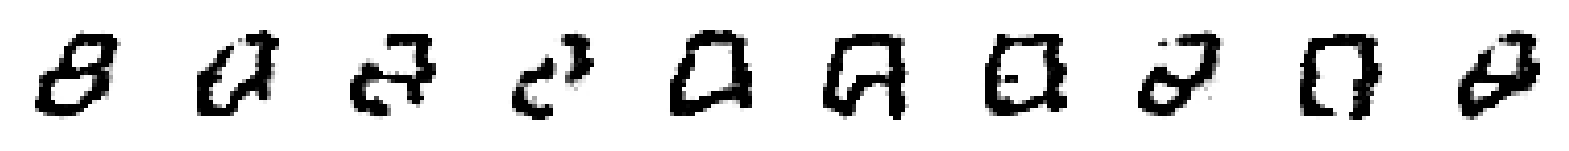


Saved to ./output/example_img_008.png


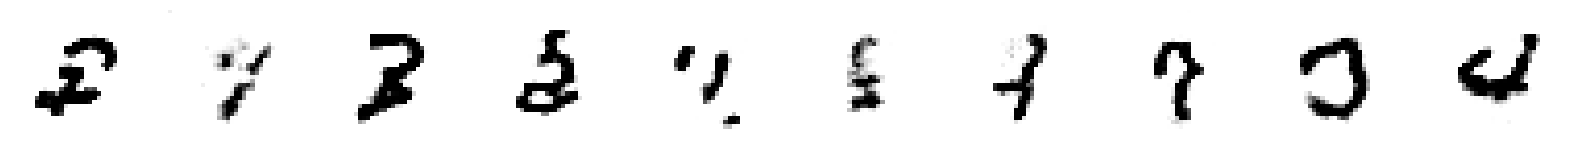

469/469 [==============================] - 489s 1s/step - loss: 6.2828e-04 - reg: 2.5945e-04 - cdiv: 3.6884e-04 - real: 9.1447e-04 - fake: 0.0013 - val_cdiv: -3.4645 - val_real: -0.0094 - val_fake: -3.4739
Epoch 10/60
469/469 [==============================] - ETA: 0s - loss: 1.0239e-04 - reg: 2.4276e-04 - cdiv: -1.4037e-04 - real: 7.2487e-04 - fake: 5.8451e-04     
Saved to ./output/generated_img_009.png


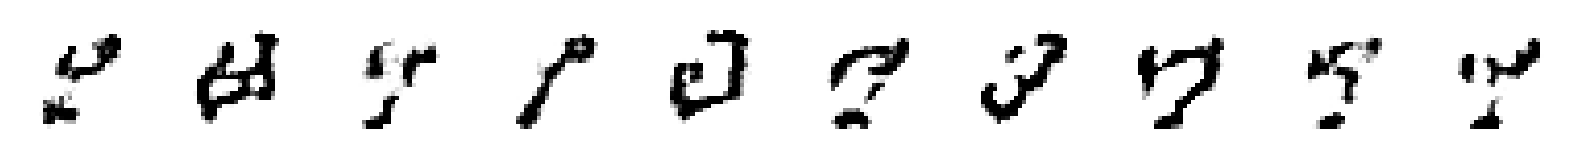


Saved to ./output/example_img_009.png


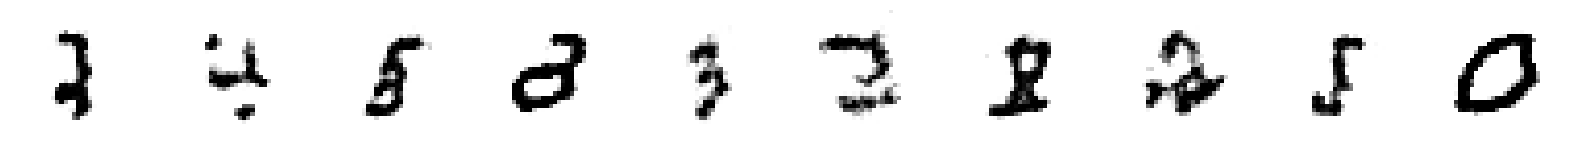

469/469 [==============================] - 439s 935ms/step - loss: 1.0239e-04 - reg: 2.4276e-04 - cdiv: -1.4037e-04 - real: 7.2487e-04 - fake: 5.8451e-04 - val_cdiv: -3.8407 - val_real: 0.0111 - val_fake: -3.8296
Epoch 11/60
469/469 [==============================] - ETA: 0s - loss: 1.5460e-04 - reg: 2.5671e-04 - cdiv: -1.0211e-04 - real: 0.0013 - fake: 0.0012             
Saved to ./output/generated_img_010.png


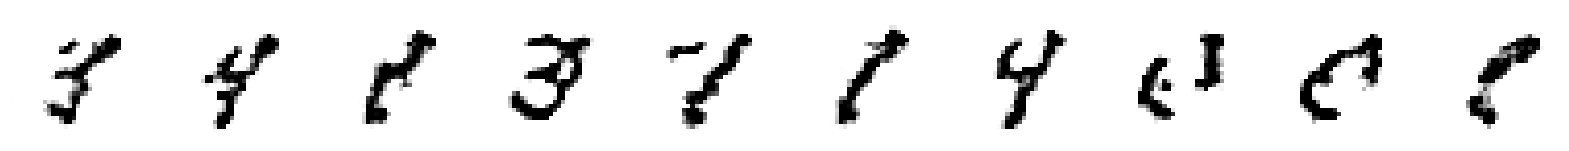


Saved to ./output/example_img_010.png


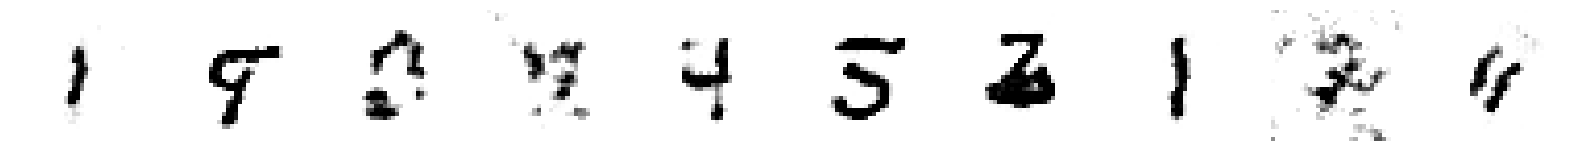

469/469 [==============================] - 418s 892ms/step - loss: 1.5460e-04 - reg: 2.5671e-04 - cdiv: -1.0211e-04 - real: 0.0013 - fake: 0.0012 - val_cdiv: -4.2316 - val_real: 0.0131 - val_fake: -4.2185
Epoch 12/60
469/469 [==============================] - ETA: 0s - loss: 1.1669e-04 - reg: 2.4135e-04 - cdiv: -1.2466e-04 - real: 0.0010 - fake: 8.9206e-04         
Saved to ./output/generated_img_011.png


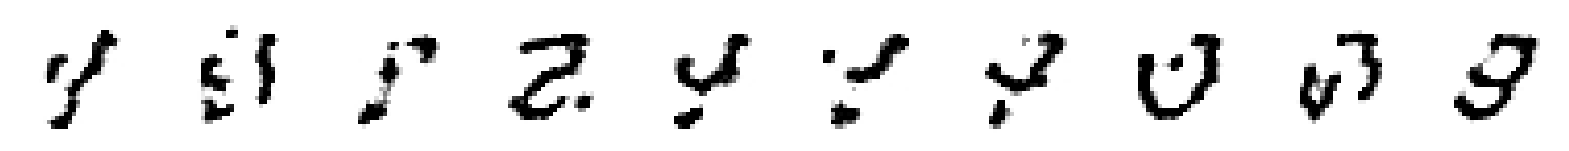


Saved to ./output/example_img_011.png


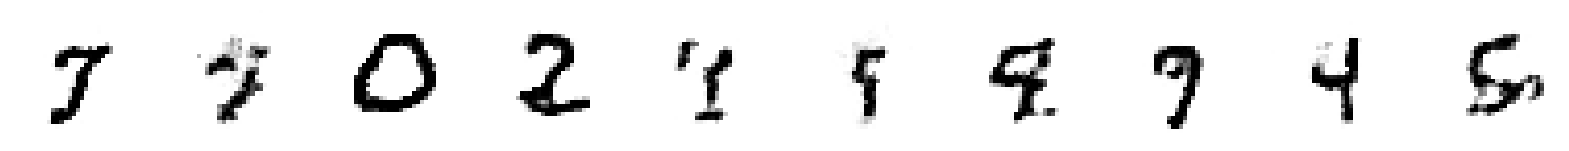

469/469 [==============================] - 415s 885ms/step - loss: 1.1669e-04 - reg: 2.4135e-04 - cdiv: -1.2466e-04 - real: 0.0010 - fake: 8.9206e-04 - val_cdiv: -4.5635 - val_real: -0.0024 - val_fake: -4.5659
Epoch 13/60
469/469 [==============================] - ETA: 0s - loss: 1.6137e-04 - reg: 2.3721e-04 - cdiv: -7.5845e-05 - real: 1.8278e-04 - fake: 1.0693e-04     
Saved to ./output/generated_img_012.png


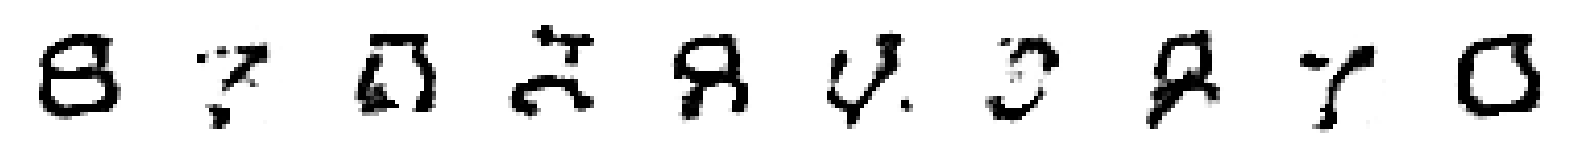


Saved to ./output/example_img_012.png


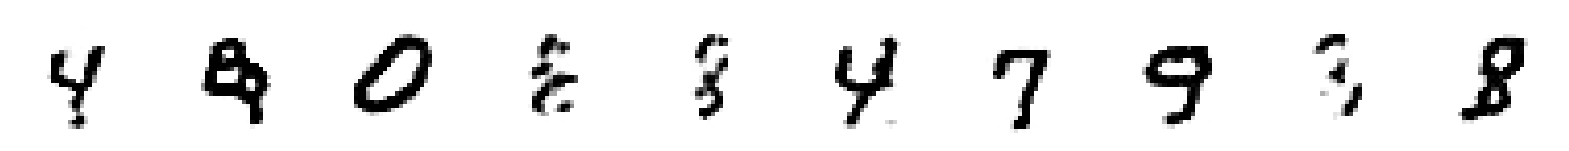

469/469 [==============================] - 414s 883ms/step - loss: 1.6137e-04 - reg: 2.3721e-04 - cdiv: -7.5845e-05 - real: 1.8278e-04 - fake: 1.0693e-04 - val_cdiv: -4.9979 - val_real: 0.0239 - val_fake: -4.9740
Epoch 14/60
469/469 [==============================] - ETA: 0s - loss: 7.5102e-05 - reg: 2.5612e-04 - cdiv: -1.8102e-04 - real: 9.6184e-04 - fake: 7.8082e-04     
Saved to ./output/generated_img_013.png


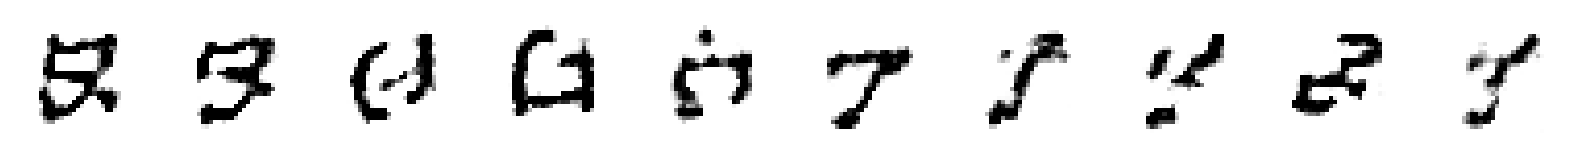


Saved to ./output/example_img_013.png


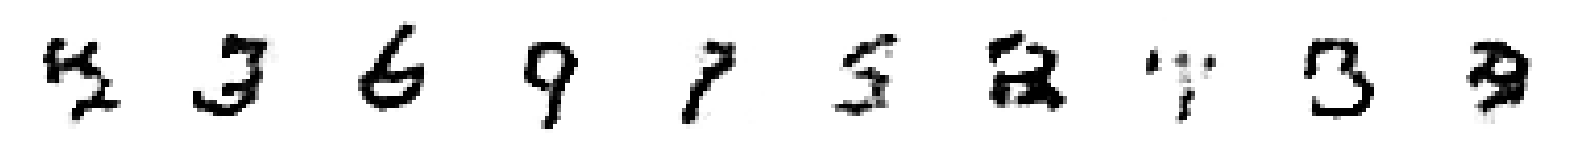

469/469 [==============================] - 416s 887ms/step - loss: 7.5102e-05 - reg: 2.5612e-04 - cdiv: -1.8102e-04 - real: 9.6184e-04 - fake: 7.8082e-04 - val_cdiv: -5.3269 - val_real: 0.0453 - val_fake: -5.2816
Epoch 15/60
469/469 [==============================] - ETA: 0s - loss: 7.4658e-05 - reg: 2.0364e-04 - cdiv: -1.2899e-04 - real: 8.8680e-04 - fake: 7.5781e-04     
Saved to ./output/generated_img_014.png


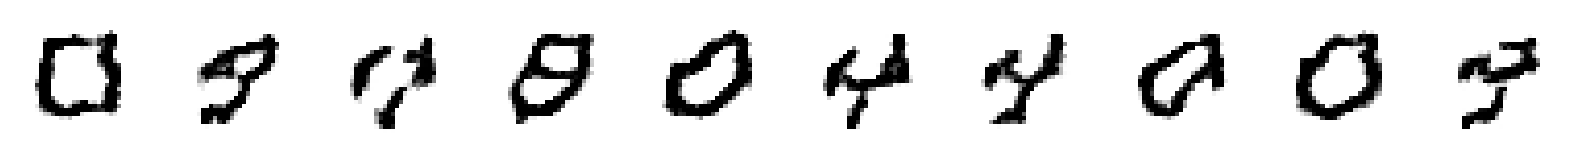


Saved to ./output/example_img_014.png


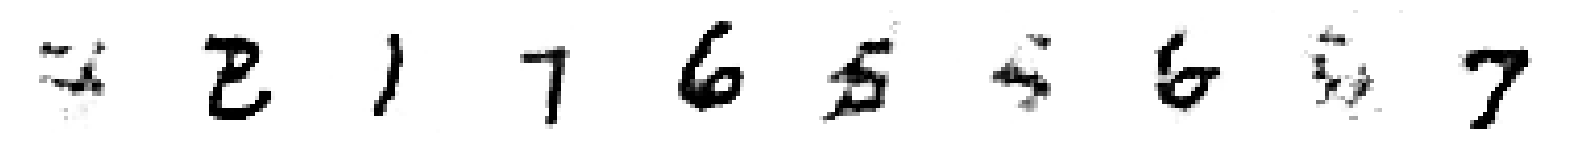

469/469 [==============================] - 415s 886ms/step - loss: 7.4658e-05 - reg: 2.0364e-04 - cdiv: -1.2899e-04 - real: 8.8680e-04 - fake: 7.5781e-04 - val_cdiv: -5.7043 - val_real: 0.0247 - val_fake: -5.6796
Epoch 16/60
469/469 [==============================] - ETA: 0s - loss: 2.2844e-04 - reg: 1.9611e-04 - cdiv: 3.2334e-05 - real: 6.4558e-04 - fake: 6.7792e-04     
Saved to ./output/generated_img_015.png


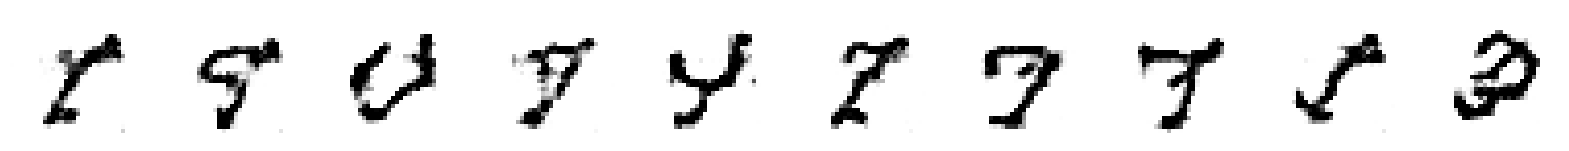


Saved to ./output/example_img_015.png


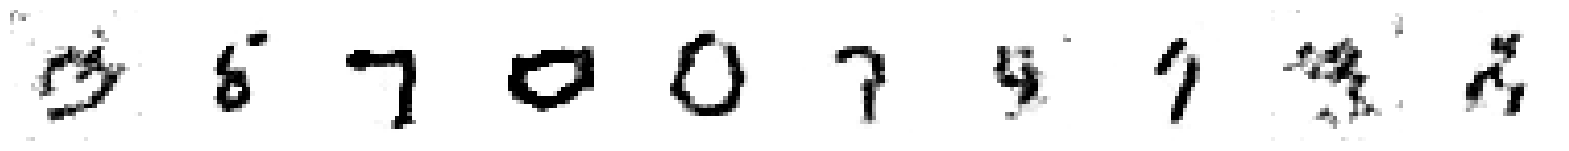

469/469 [==============================] - 414s 883ms/step - loss: 2.2844e-04 - reg: 1.9611e-04 - cdiv: 3.2334e-05 - real: 6.4558e-04 - fake: 6.7792e-04 - val_cdiv: -6.0526 - val_real: 0.0412 - val_fake: -6.0114
Epoch 17/60
469/469 [==============================] - ETA: 0s - loss: -1.2805e-04 - reg: 2.0929e-04 - cdiv: -3.3734e-04 - real: 7.8680e-04 - fake: 4.4946e-04    
Saved to ./output/generated_img_016.png


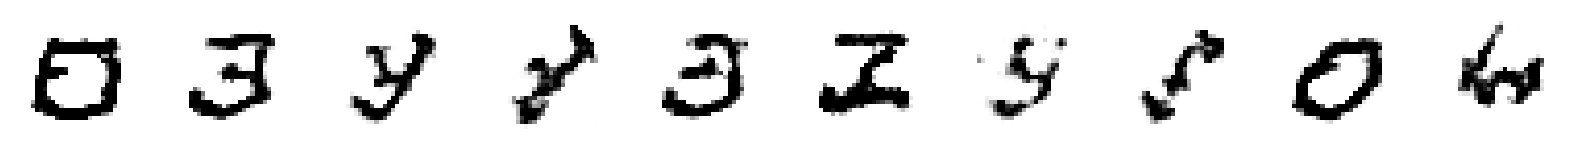


Saved to ./output/example_img_016.png


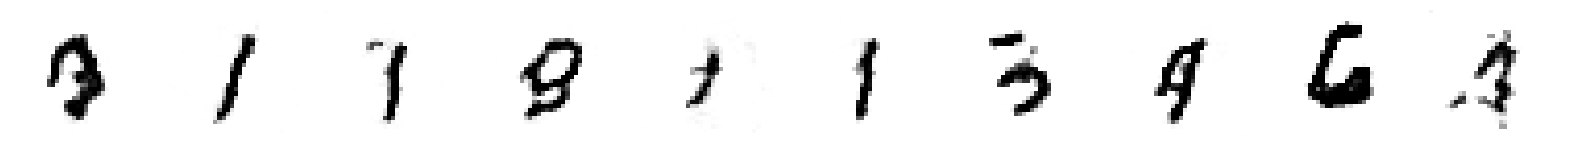

469/469 [==============================] - 415s 884ms/step - loss: -1.2805e-04 - reg: 2.0929e-04 - cdiv: -3.3734e-04 - real: 7.8680e-04 - fake: 4.4946e-04 - val_cdiv: -6.5078 - val_real: 0.0213 - val_fake: -6.4865
Epoch 18/60
469/469 [==============================] - ETA: 0s - loss: 2.3631e-04 - reg: 2.1684e-04 - cdiv: 1.9473e-05 - real: 6.3789e-04 - fake: 6.5736e-04      
Saved to ./output/generated_img_017.png


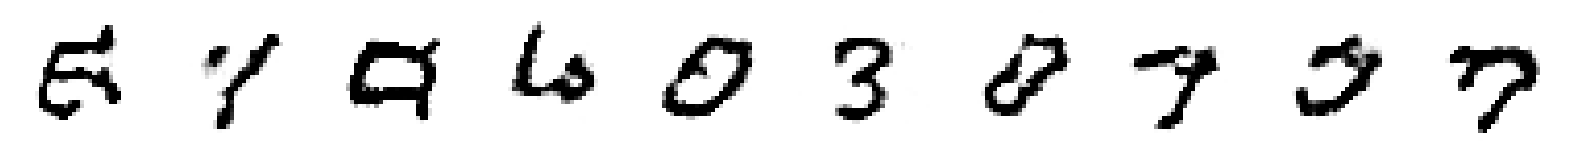


Saved to ./output/example_img_017.png


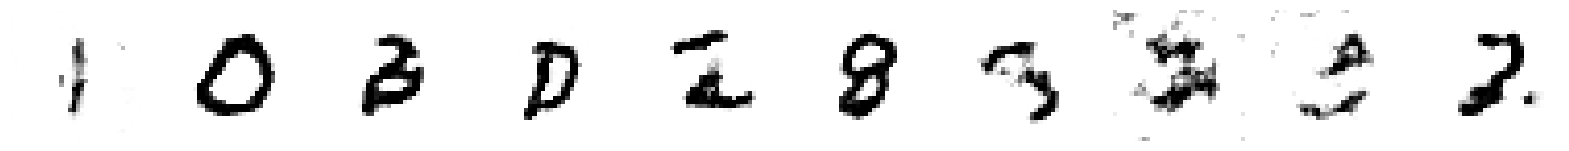

469/469 [==============================] - 411s 875ms/step - loss: 2.3631e-04 - reg: 2.1684e-04 - cdiv: 1.9473e-05 - real: 6.3789e-04 - fake: 6.5736e-04 - val_cdiv: -6.6922 - val_real: 0.0112 - val_fake: -6.6810
Epoch 19/60
469/469 [==============================] - ETA: 0s - loss: 1.9899e-04 - reg: 1.8470e-04 - cdiv: 1.4291e-05 - real: 6.8769e-04 - fake: 7.0198e-04      
Saved to ./output/generated_img_018.png


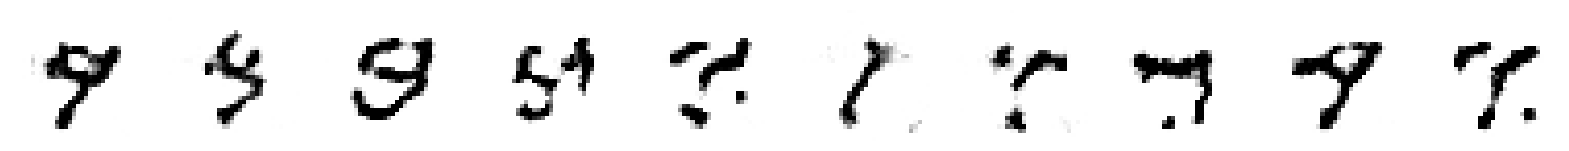


Saved to ./output/example_img_018.png


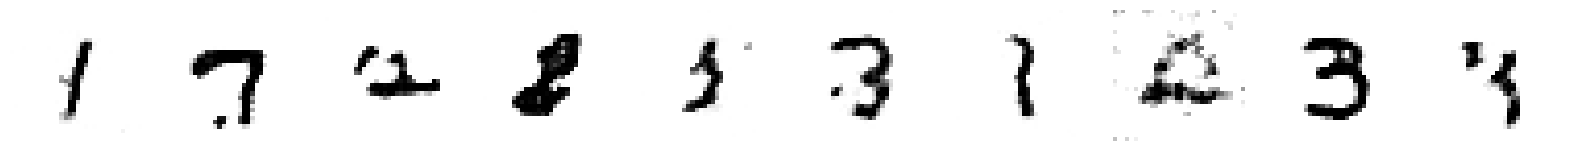

469/469 [==============================] - 412s 878ms/step - loss: 1.9899e-04 - reg: 1.8470e-04 - cdiv: 1.4291e-05 - real: 6.8769e-04 - fake: 7.0198e-04 - val_cdiv: -7.0782 - val_real: 0.0214 - val_fake: -7.0567
Epoch 20/60
469/469 [==============================] - ETA: 0s - loss: -8.3374e-05 - reg: 1.7331e-04 - cdiv: -2.5669e-04 - real: 6.0282e-04 - fake: 3.4614e-04    
Saved to ./output/generated_img_019.png


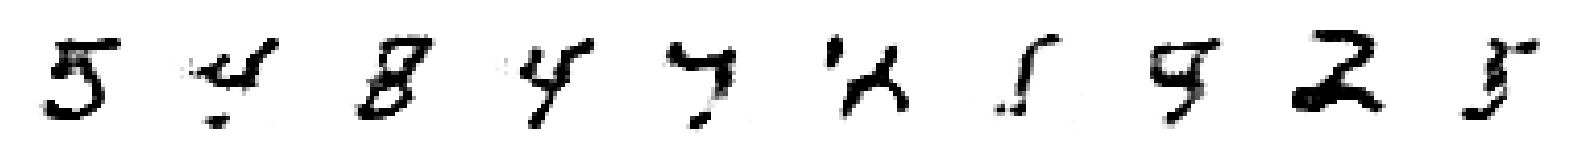


Saved to ./output/example_img_019.png


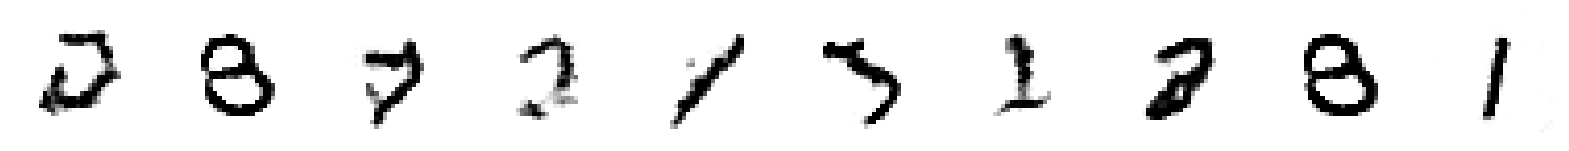

469/469 [==============================] - 409s 871ms/step - loss: -8.3374e-05 - reg: 1.7331e-04 - cdiv: -2.5669e-04 - real: 6.0282e-04 - fake: 3.4614e-04 - val_cdiv: -7.4091 - val_real: 0.0131 - val_fake: -7.3960
Epoch 21/60
469/469 [==============================] - ETA: 0s - loss: 7.0805e-05 - reg: 1.8484e-04 - cdiv: -1.1404e-04 - real: 3.5565e-04 - fake: 2.4161e-04     
Saved to ./output/generated_img_020.png


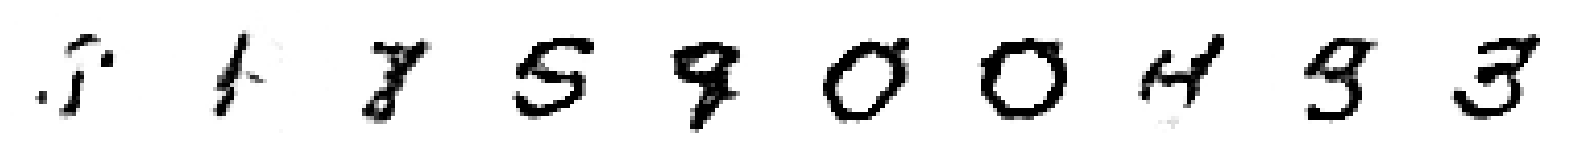


Saved to ./output/example_img_020.png


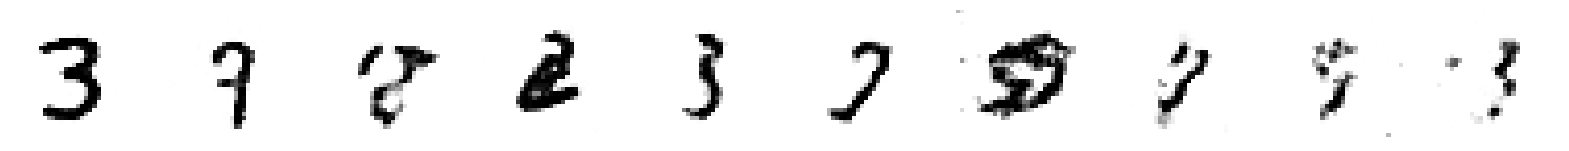

469/469 [==============================] - 407s 869ms/step - loss: 7.0805e-05 - reg: 1.8484e-04 - cdiv: -1.1404e-04 - real: 3.5565e-04 - fake: 2.4161e-04 - val_cdiv: -7.7375 - val_real: 0.0161 - val_fake: -7.7215
Epoch 22/60
469/469 [==============================] - ETA: 0s - loss: 5.2034e-05 - reg: 1.5316e-04 - cdiv: -1.0113e-04 - real: 7.0434e-04 - fake: 6.0321e-04     
Saved to ./output/generated_img_021.png


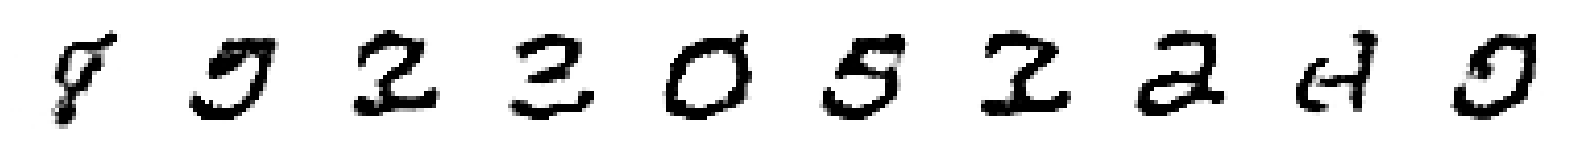


Saved to ./output/example_img_021.png


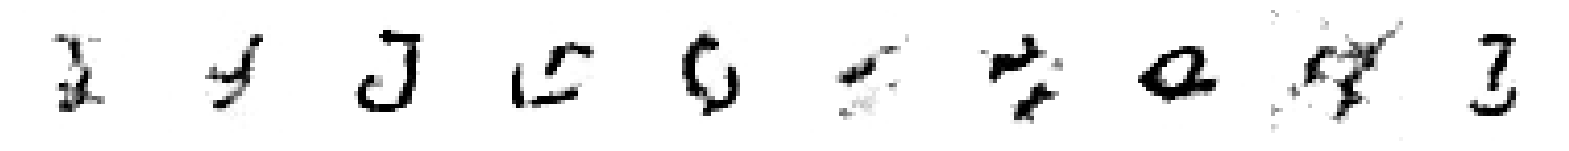

469/469 [==============================] - 412s 879ms/step - loss: 5.2034e-05 - reg: 1.5316e-04 - cdiv: -1.0113e-04 - real: 7.0434e-04 - fake: 6.0321e-04 - val_cdiv: -7.9847 - val_real: 0.0113 - val_fake: -7.9734
Epoch 23/60
469/469 [==============================] - ETA: 0s - loss: 1.5270e-06 - reg: 1.8201e-04 - cdiv: -1.8049e-04 - real: 3.6462e-04 - fake: 1.8413e-04     
Saved to ./output/generated_img_022.png


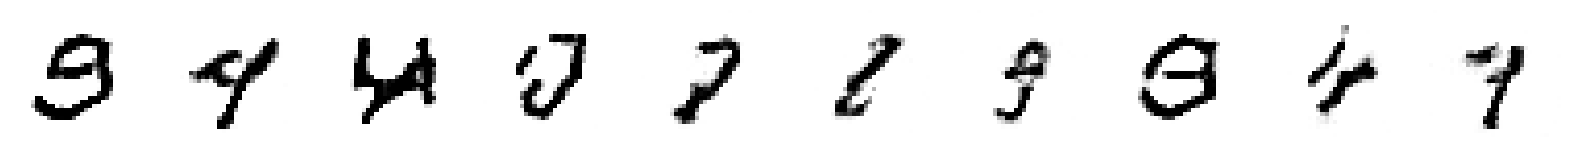


Saved to ./output/example_img_022.png


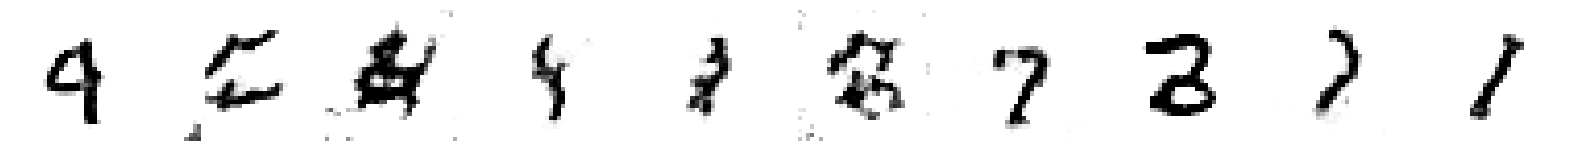

469/469 [==============================] - 411s 876ms/step - loss: 1.5270e-06 - reg: 1.8201e-04 - cdiv: -1.8049e-04 - real: 3.6462e-04 - fake: 1.8413e-04 - val_cdiv: -8.3982 - val_real: 0.0123 - val_fake: -8.3859
Epoch 24/60
469/469 [==============================] - ETA: 0s - loss: 2.1120e-04 - reg: 1.5476e-04 - cdiv: 5.6445e-05 - real: 8.2160e-04 - fake: 8.7805e-04      
Saved to ./output/generated_img_023.png


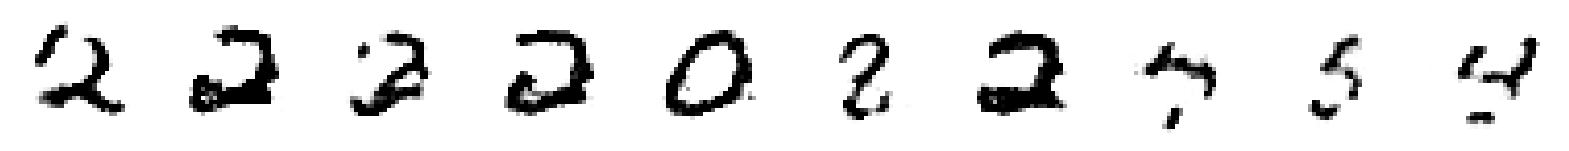


Saved to ./output/example_img_023.png


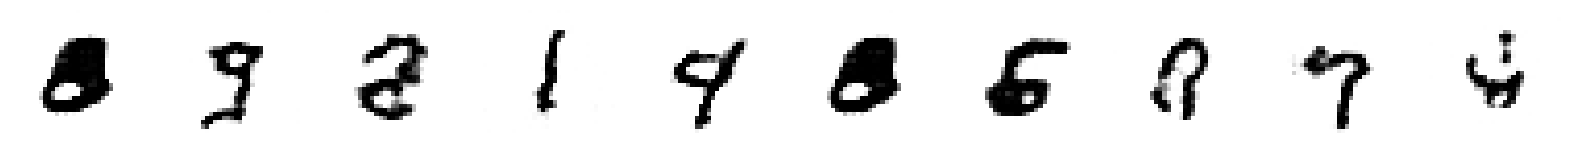

469/469 [==============================] - 413s 881ms/step - loss: 2.1120e-04 - reg: 1.5476e-04 - cdiv: 5.6445e-05 - real: 8.2160e-04 - fake: 8.7805e-04 - val_cdiv: -8.7580 - val_real: 0.0175 - val_fake: -8.7405
Epoch 25/60
469/469 [==============================] - ETA: 0s - loss: 4.5416e-05 - reg: 1.6208e-04 - cdiv: -1.1666e-04 - real: 1.7600e-04 - fake: 5.9344e-05     
Saved to ./output/generated_img_024.png


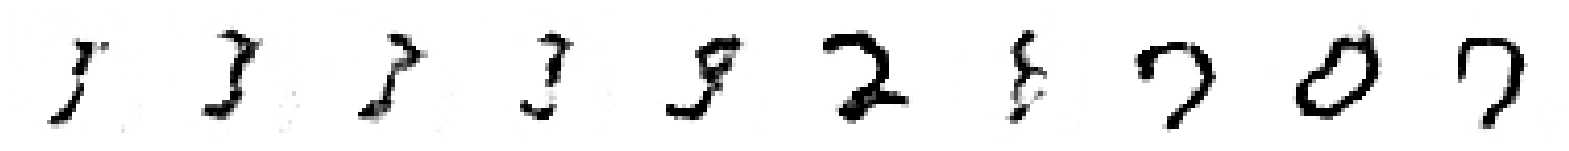


Saved to ./output/example_img_024.png


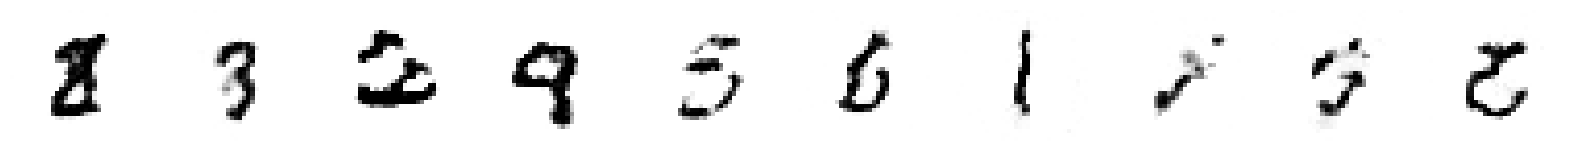

469/469 [==============================] - 409s 872ms/step - loss: 4.5416e-05 - reg: 1.6208e-04 - cdiv: -1.1666e-04 - real: 1.7600e-04 - fake: 5.9344e-05 - val_cdiv: -9.0728 - val_real: 0.0208 - val_fake: -9.0521
Epoch 26/60
469/469 [==============================] - ETA: 0s - loss: 1.1589e-04 - reg: 1.4906e-04 - cdiv: -3.3167e-05 - real: 5.6936e-04 - fake: 5.3619e-04     
Saved to ./output/generated_img_025.png


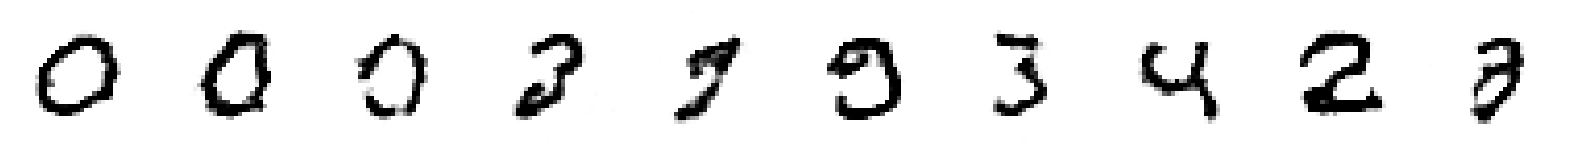


Saved to ./output/example_img_025.png


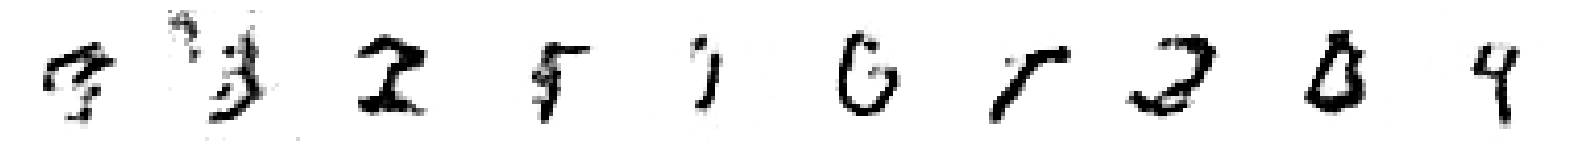

469/469 [==============================] - 411s 876ms/step - loss: 1.1589e-04 - reg: 1.4906e-04 - cdiv: -3.3167e-05 - real: 5.6936e-04 - fake: 5.3619e-04 - val_cdiv: -9.5042 - val_real: 0.0118 - val_fake: -9.4924
Epoch 27/60
469/469 [==============================] - ETA: 0s - loss: -2.8022e-04 - reg: 1.6012e-04 - cdiv: -4.4033e-04 - real: 8.6705e-04 - fake: 4.2671e-04    
Saved to ./output/generated_img_026.png


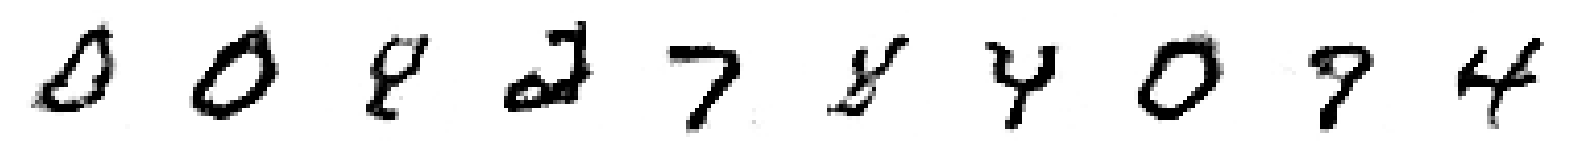


Saved to ./output/example_img_026.png


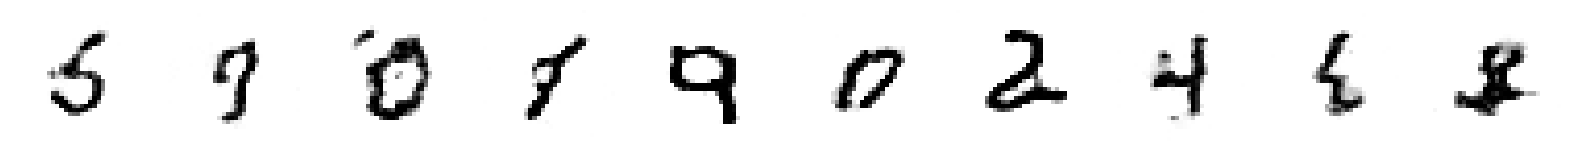

469/469 [==============================] - 413s 881ms/step - loss: -2.8022e-04 - reg: 1.6012e-04 - cdiv: -4.4033e-04 - real: 8.6705e-04 - fake: 4.2671e-04 - val_cdiv: -9.9540 - val_real: 0.0089 - val_fake: -9.9451
Epoch 28/60
469/469 [==============================] - ETA: 0s - loss: 1.9688e-04 - reg: 1.4642e-04 - cdiv: 5.0458e-05 - real: 1.3617e-04 - fake: 1.8663e-04      
Saved to ./output/generated_img_027.png


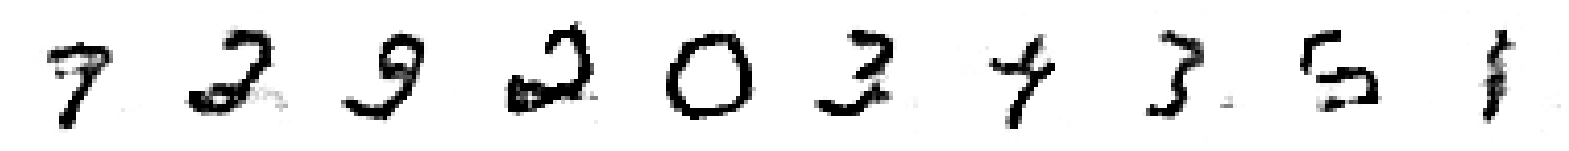


Saved to ./output/example_img_027.png


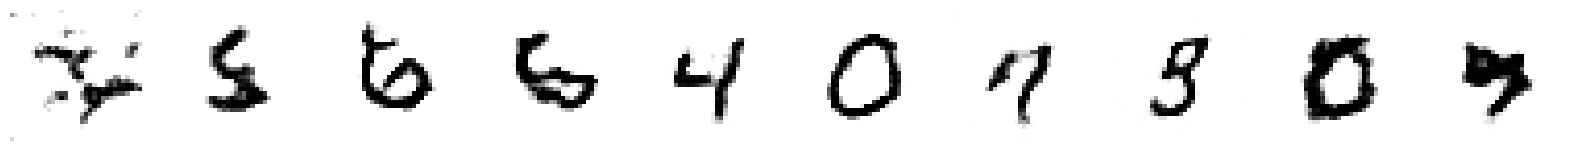

469/469 [==============================] - 412s 879ms/step - loss: 1.9688e-04 - reg: 1.4642e-04 - cdiv: 5.0458e-05 - real: 1.3617e-04 - fake: 1.8663e-04 - val_cdiv: -10.4247 - val_real: 0.0234 - val_fake: -10.4013
Epoch 29/60
469/469 [==============================] - ETA: 0s - loss: -9.1052e-06 - reg: 1.4221e-04 - cdiv: -1.5131e-04 - real: 6.6528e-04 - fake: 5.1397e-04    
Saved to ./output/generated_img_028.png


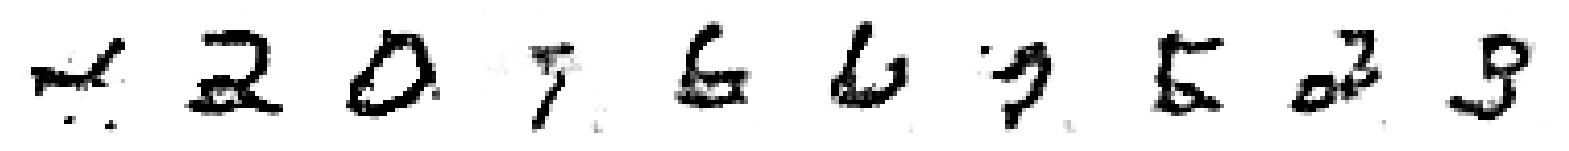


Saved to ./output/example_img_028.png


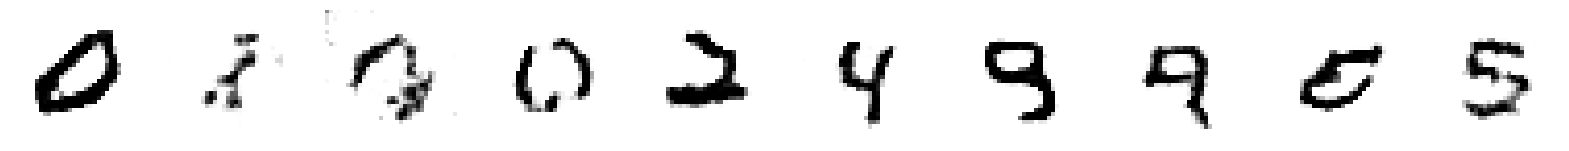

469/469 [==============================] - 413s 880ms/step - loss: -9.1052e-06 - reg: 1.4221e-04 - cdiv: -1.5131e-04 - real: 6.6528e-04 - fake: 5.1397e-04 - val_cdiv: -10.9708 - val_real: 0.0262 - val_fake: -10.9446
Epoch 30/60
469/469 [==============================] - ETA: 0s - loss: 1.5086e-04 - reg: 1.3869e-04 - cdiv: 1.2169e-05 - real: 2.8729e-04 - fake: 2.9946e-04     
Saved to ./output/generated_img_029.png


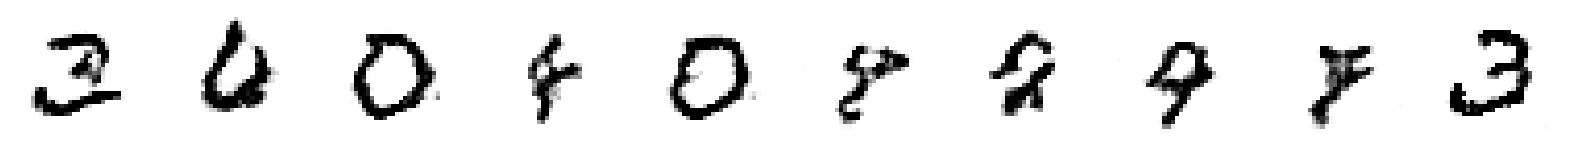


Saved to ./output/example_img_029.png


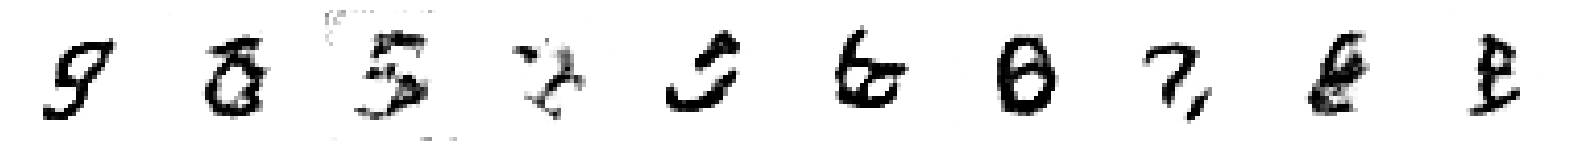

469/469 [==============================] - 413s 880ms/step - loss: 1.5086e-04 - reg: 1.3869e-04 - cdiv: 1.2169e-05 - real: 2.8729e-04 - fake: 2.9946e-04 - val_cdiv: -10.9889 - val_real: 0.0168 - val_fake: -10.9721
Epoch 31/60
469/469 [==============================] - ETA: 0s - loss: 2.2490e-05 - reg: 1.3439e-04 - cdiv: -1.1190e-04 - real: 4.8919e-04 - fake: 3.7729e-04     
Saved to ./output/generated_img_030.png


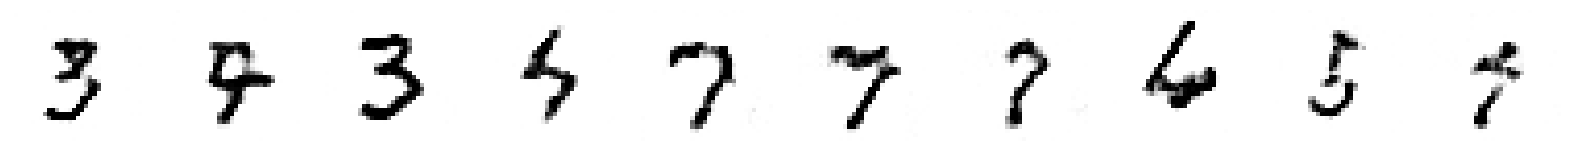


Saved to ./output/example_img_030.png


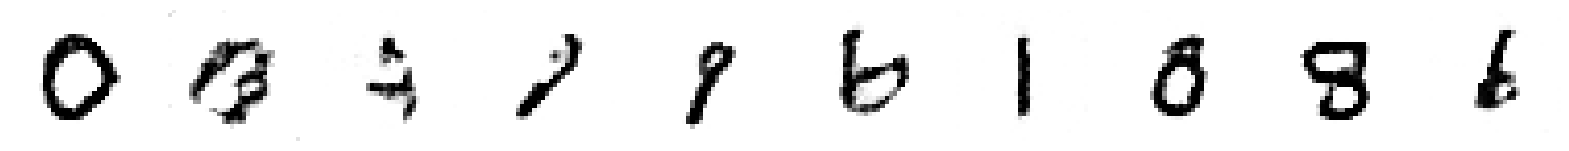

469/469 [==============================] - 416s 888ms/step - loss: 2.2490e-05 - reg: 1.3439e-04 - cdiv: -1.1190e-04 - real: 4.8919e-04 - fake: 3.7729e-04 - val_cdiv: -11.5132 - val_real: 0.0100 - val_fake: -11.5033
Epoch 32/60
469/469 [==============================] - ETA: 0s - loss: -1.0489e-04 - reg: 1.4561e-04 - cdiv: -2.5050e-04 - real: 6.4730e-04 - fake: 3.9680e-04    
Saved to ./output/generated_img_031.png


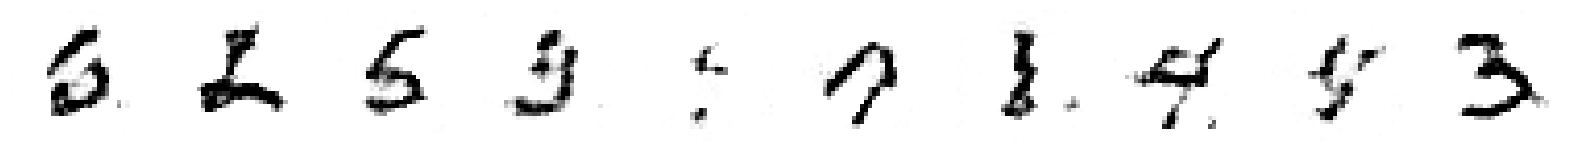


Saved to ./output/example_img_031.png


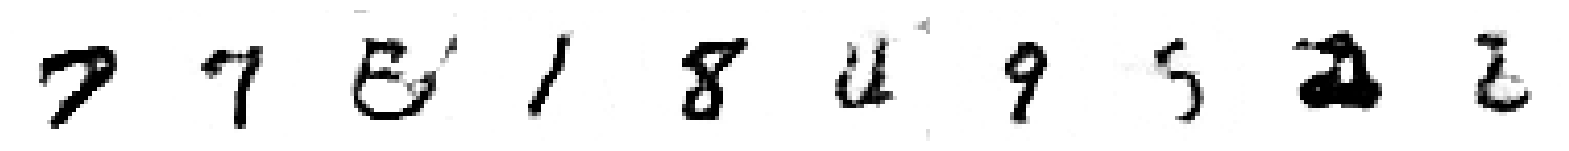

469/469 [==============================] - 417s 889ms/step - loss: -1.0489e-04 - reg: 1.4561e-04 - cdiv: -2.5050e-04 - real: 6.4730e-04 - fake: 3.9680e-04 - val_cdiv: -12.2791 - val_real: 0.0203 - val_fake: -12.2588
Epoch 33/60
469/469 [==============================] - ETA: 0s - loss: 1.6128e-04 - reg: 1.0480e-04 - cdiv: 5.6473e-05 - real: 2.8424e-04 - fake: 3.4071e-04      
Saved to ./output/generated_img_032.png


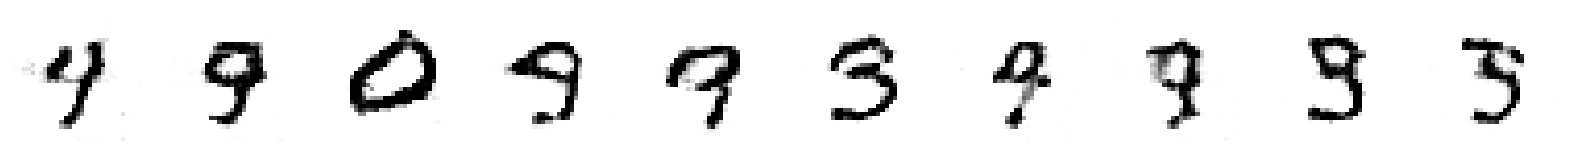


Saved to ./output/example_img_032.png


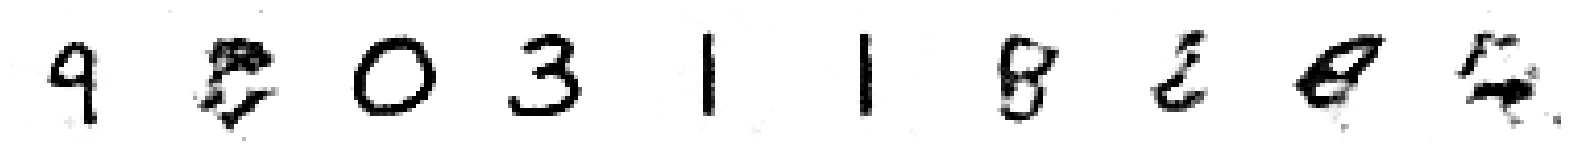

469/469 [==============================] - 414s 882ms/step - loss: 1.6128e-04 - reg: 1.0480e-04 - cdiv: 5.6473e-05 - real: 2.8424e-04 - fake: 3.4071e-04 - val_cdiv: -12.6769 - val_real: 0.0092 - val_fake: -12.6677
Epoch 34/60
469/469 [==============================] - ETA: 0s - loss: -9.1241e-05 - reg: 1.5240e-04 - cdiv: -2.4364e-04 - real: 4.6946e-04 - fake: 2.2582e-04    
Saved to ./output/generated_img_033.png


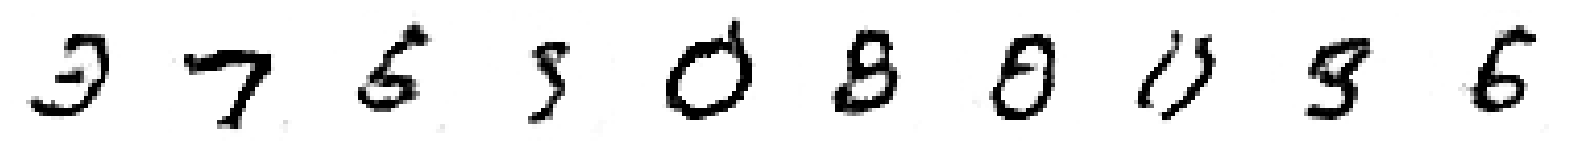


Saved to ./output/example_img_033.png


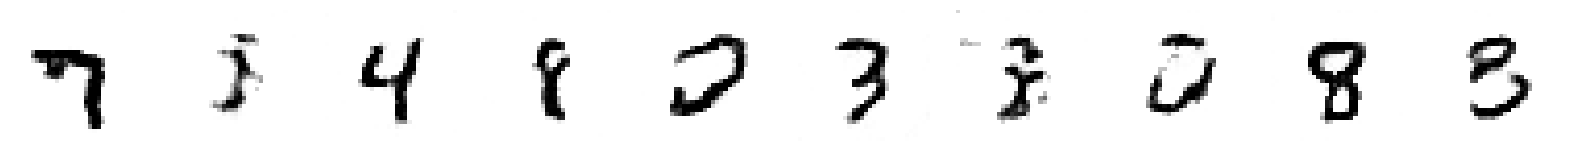

469/469 [==============================] - 410s 874ms/step - loss: -9.1241e-05 - reg: 1.5240e-04 - cdiv: -2.4364e-04 - real: 4.6946e-04 - fake: 2.2582e-04 - val_cdiv: -12.8431 - val_real: 0.0114 - val_fake: -12.8317
Epoch 35/60
469/469 [==============================] - ETA: 0s - loss: 1.2853e-04 - reg: 1.3617e-04 - cdiv: -7.6442e-06 - real: 4.7211e-04 - fake: 4.6446e-04     
Saved to ./output/generated_img_034.png


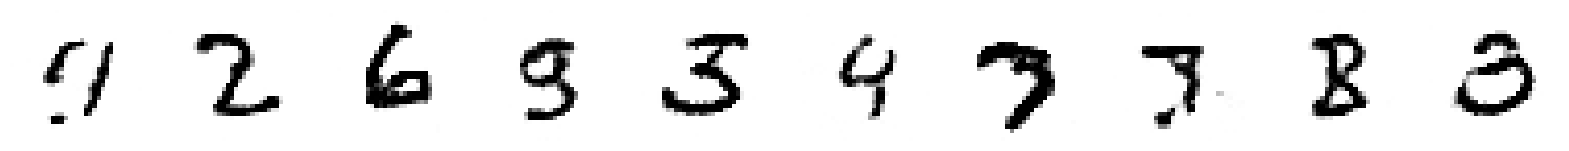


Saved to ./output/example_img_034.png


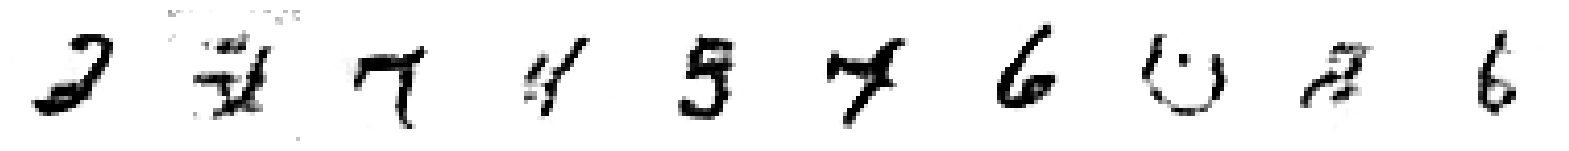

469/469 [==============================] - 416s 886ms/step - loss: 1.2853e-04 - reg: 1.3617e-04 - cdiv: -7.6442e-06 - real: 4.7211e-04 - fake: 4.6446e-04 - val_cdiv: -13.1655 - val_real: 0.0037 - val_fake: -13.1618
Epoch 36/60
469/469 [==============================] - ETA: 0s - loss: -9.3900e-06 - reg: 1.4409e-04 - cdiv: -1.5348e-04 - real: 2.5131e-04 - fake: 9.7821e-05    
Saved to ./output/generated_img_035.png


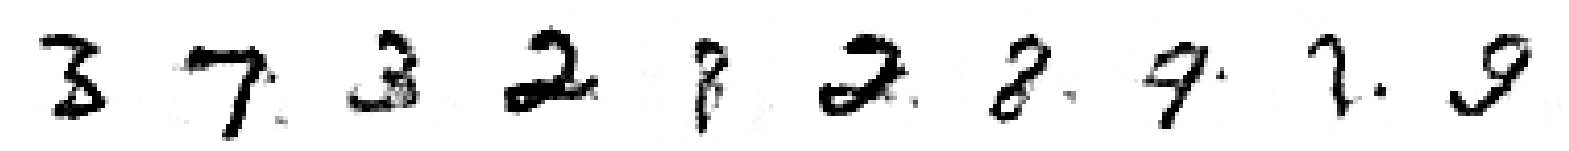


Saved to ./output/example_img_035.png


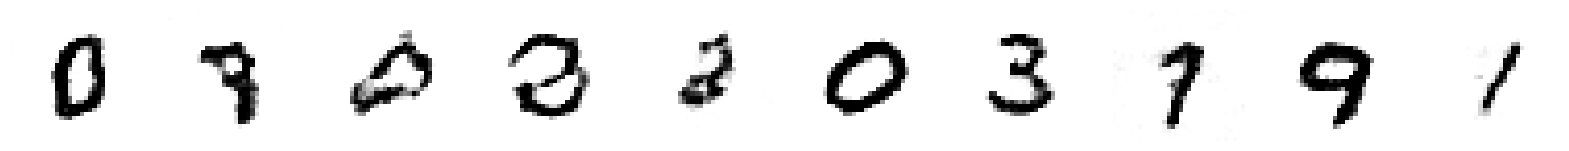

469/469 [==============================] - 412s 879ms/step - loss: -9.3900e-06 - reg: 1.4409e-04 - cdiv: -1.5348e-04 - real: 2.5131e-04 - fake: 9.7821e-05 - val_cdiv: -13.8921 - val_real: 0.0184 - val_fake: -13.8737
Epoch 37/60
469/469 [==============================] - ETA: 0s - loss: 1.2772e-04 - reg: 1.4070e-04 - cdiv: -1.2974e-05 - real: 5.6250e-04 - fake: 5.4953e-04     
Saved to ./output/generated_img_036.png


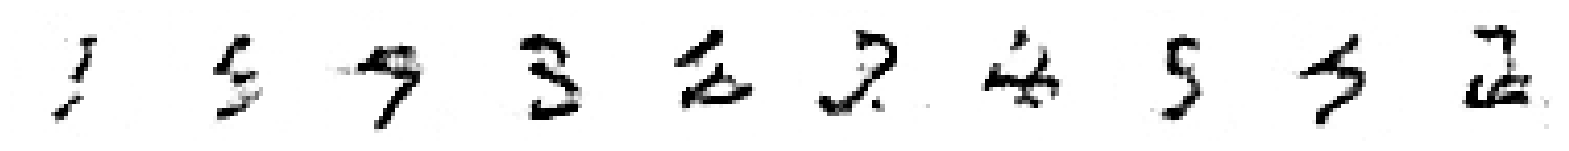


Saved to ./output/example_img_036.png


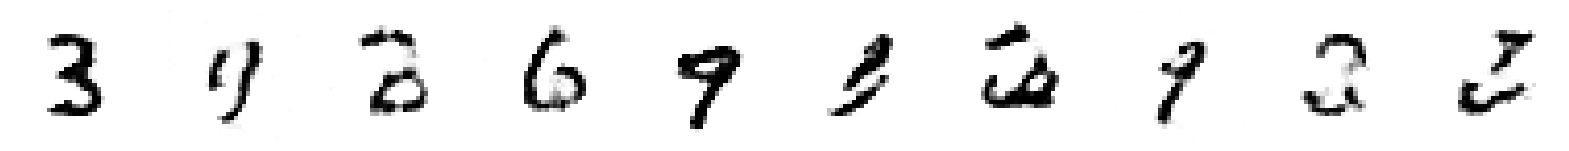

469/469 [==============================] - 411s 877ms/step - loss: 1.2772e-04 - reg: 1.4070e-04 - cdiv: -1.2974e-05 - real: 5.6250e-04 - fake: 5.4953e-04 - val_cdiv: -14.3543 - val_real: 0.0152 - val_fake: -14.3391
Epoch 38/60
469/469 [==============================] - ETA: 0s - loss: -4.3140e-05 - reg: 1.2476e-04 - cdiv: -1.6790e-04 - real: 2.9510e-04 - fake: 1.2721e-04    
Saved to ./output/generated_img_037.png


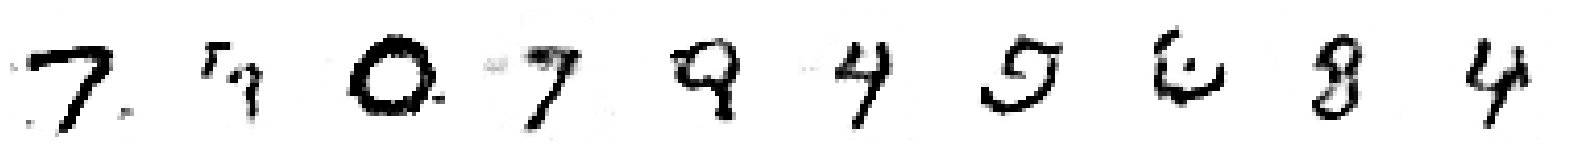


Saved to ./output/example_img_037.png


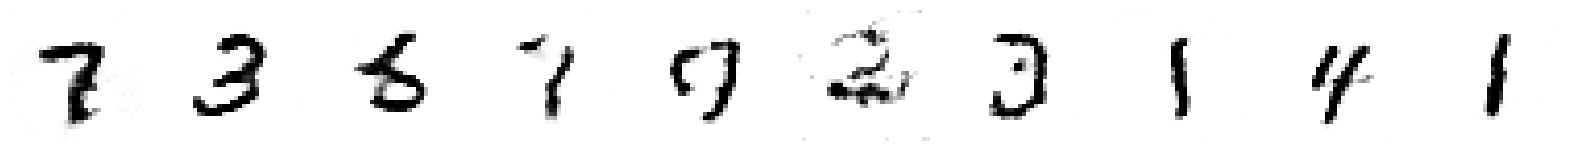

469/469 [==============================] - 410s 875ms/step - loss: -4.3140e-05 - reg: 1.2476e-04 - cdiv: -1.6790e-04 - real: 2.9510e-04 - fake: 1.2721e-04 - val_cdiv: -14.7826 - val_real: 0.0088 - val_fake: -14.7738
Epoch 39/60
469/469 [==============================] - ETA: 0s - loss: -6.2890e-05 - reg: 1.3987e-04 - cdiv: -2.0276e-04 - real: 3.8504e-04 - fake: 1.8228e-04    
Saved to ./output/generated_img_038.png


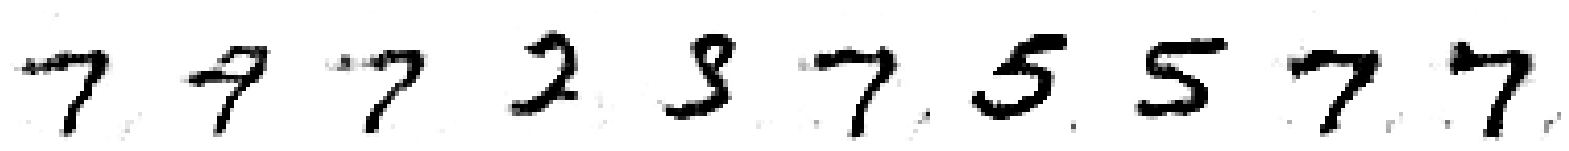


Saved to ./output/example_img_038.png


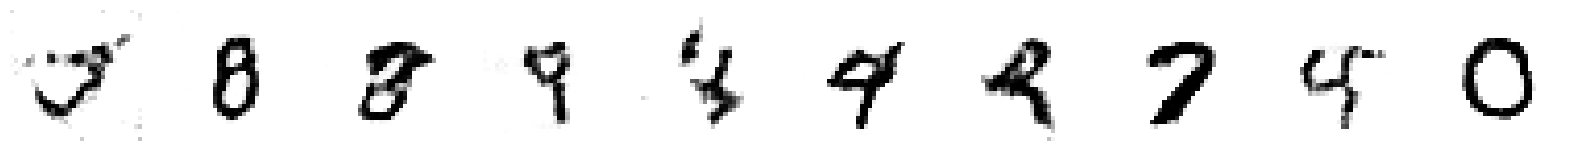

469/469 [==============================] - 413s 880ms/step - loss: -6.2890e-05 - reg: 1.3987e-04 - cdiv: -2.0276e-04 - real: 3.8504e-04 - fake: 1.8228e-04 - val_cdiv: -15.1229 - val_real: 0.0113 - val_fake: -15.1116
Epoch 40/60
469/469 [==============================] - ETA: 0s - loss: 2.3974e-04 - reg: 1.1327e-04 - cdiv: 1.2647e-04 - real: 1.3367e-04 - fake: 2.6014e-04     
Saved to ./output/generated_img_039.png


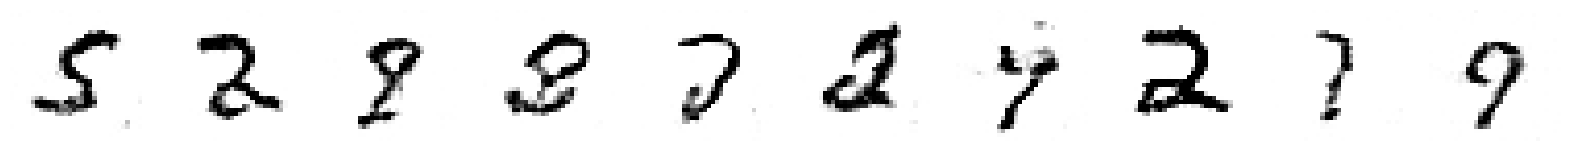


Saved to ./output/example_img_039.png


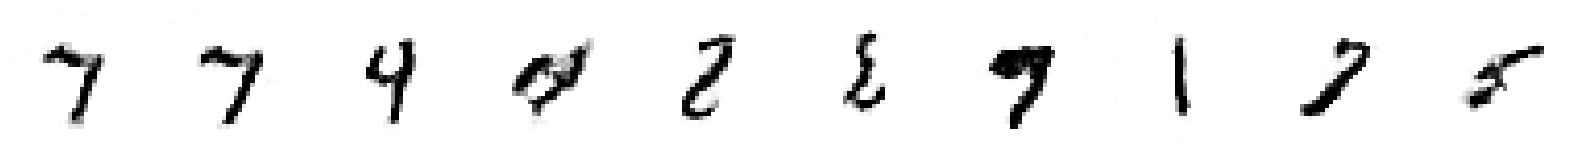

469/469 [==============================] - 412s 879ms/step - loss: 2.3974e-04 - reg: 1.1327e-04 - cdiv: 1.2647e-04 - real: 1.3367e-04 - fake: 2.6014e-04 - val_cdiv: -15.7806 - val_real: 0.0120 - val_fake: -15.7686
Epoch 41/60
469/469 [==============================] - ETA: 0s - loss: 4.9340e-05 - reg: 1.4735e-04 - cdiv: -9.8008e-05 - real: 5.7815e-04 - fake: 4.8014e-04     
Saved to ./output/generated_img_040.png


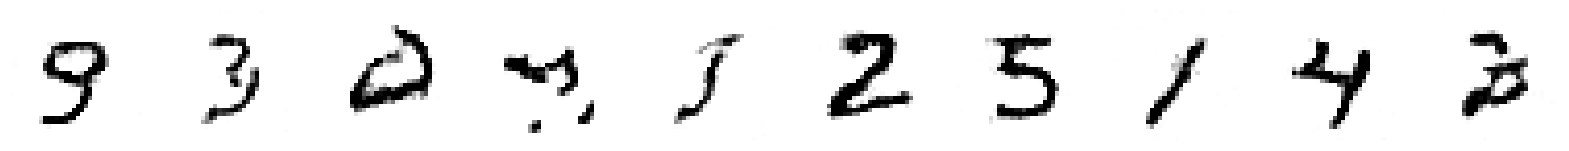


Saved to ./output/example_img_040.png


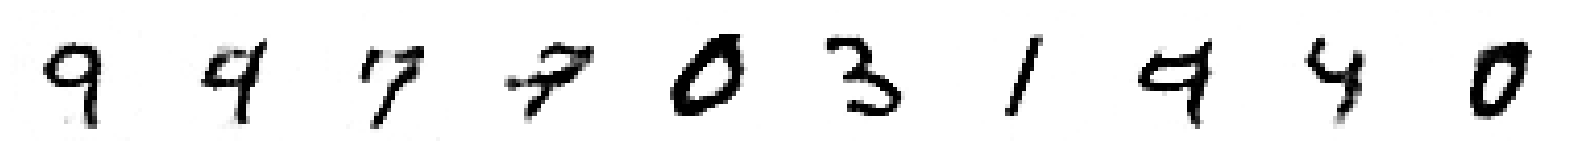

469/469 [==============================] - 416s 888ms/step - loss: 4.9340e-05 - reg: 1.4735e-04 - cdiv: -9.8008e-05 - real: 5.7815e-04 - fake: 4.8014e-04 - val_cdiv: -16.0089 - val_real: 0.0054 - val_fake: -16.0035
Epoch 42/60
469/469 [==============================] - ETA: 0s - loss: 3.3321e-06 - reg: 1.2242e-04 - cdiv: -1.1909e-04 - real: 2.4581e-04 - fake: 1.2673e-04     
Saved to ./output/generated_img_041.png


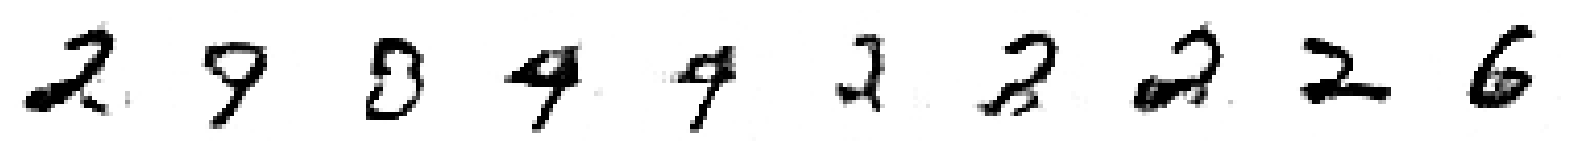


Saved to ./output/example_img_041.png


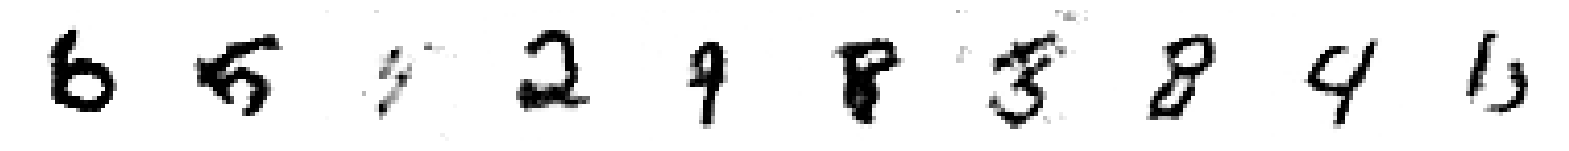

469/469 [==============================] - 415s 885ms/step - loss: 3.3321e-06 - reg: 1.2242e-04 - cdiv: -1.1909e-04 - real: 2.4581e-04 - fake: 1.2673e-04 - val_cdiv: -16.2654 - val_real: 0.0031 - val_fake: -16.2623
Epoch 43/60
469/469 [==============================] - ETA: 0s - loss: 1.2145e-04 - reg: 1.1662e-04 - cdiv: 4.8339e-06 - real: 1.2231e-04 - fake: 1.2714e-04      
Saved to ./output/generated_img_042.png


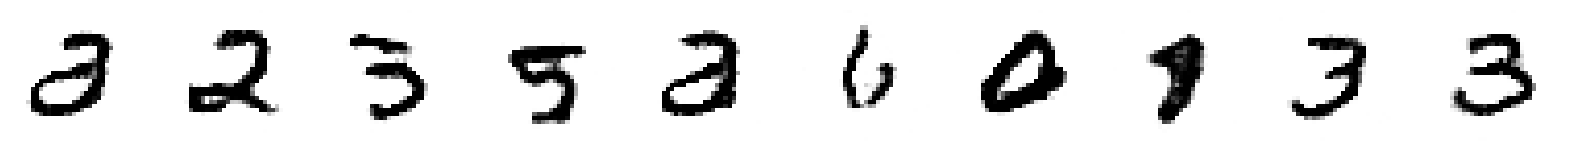


Saved to ./output/example_img_042.png


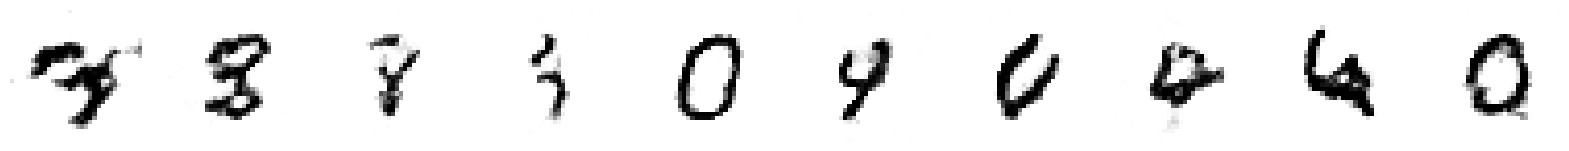

469/469 [==============================] - 412s 878ms/step - loss: 1.2145e-04 - reg: 1.1662e-04 - cdiv: 4.8339e-06 - real: 1.2231e-04 - fake: 1.2714e-04 - val_cdiv: -16.7978 - val_real: 0.0025 - val_fake: -16.7954
Epoch 44/60
469/469 [==============================] - ETA: 0s - loss: 1.1890e-04 - reg: 1.2736e-04 - cdiv: -8.4585e-06 - real: 4.8299e-04 - fake: 4.7453e-04     
Saved to ./output/generated_img_043.png


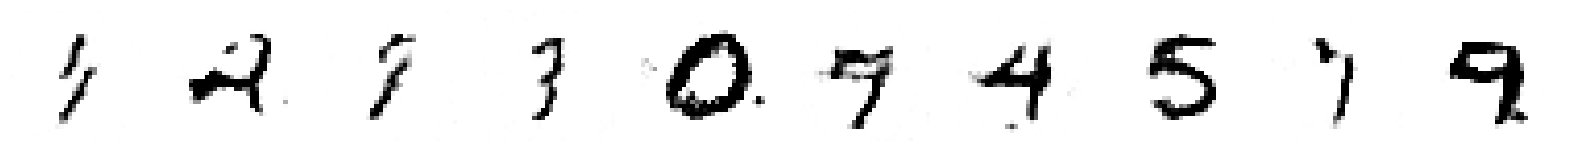


Saved to ./output/example_img_043.png


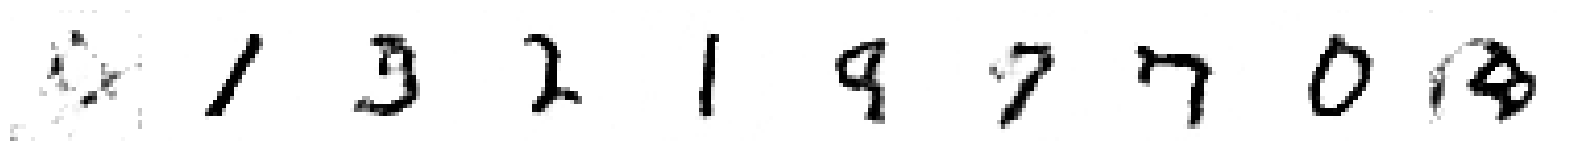

469/469 [==============================] - 415s 884ms/step - loss: 1.1890e-04 - reg: 1.2736e-04 - cdiv: -8.4585e-06 - real: 4.8299e-04 - fake: 4.7453e-04 - val_cdiv: -17.1566 - val_real: 0.0110 - val_fake: -17.1456
Epoch 45/60
469/469 [==============================] - ETA: 0s - loss: -6.6013e-06 - reg: 1.2443e-04 - cdiv: -1.3103e-04 - real: 4.0465e-04 - fake: 2.7362e-04    
Saved to ./output/generated_img_044.png


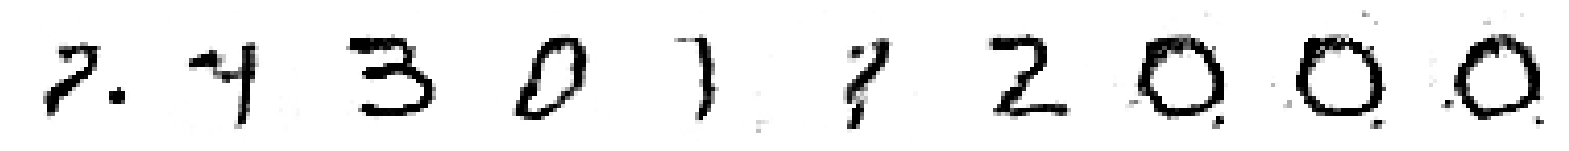


Saved to ./output/example_img_044.png


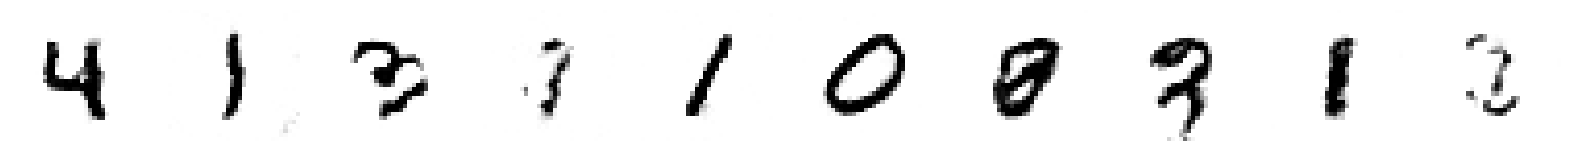

469/469 [==============================] - 420s 896ms/step - loss: -6.6013e-06 - reg: 1.2443e-04 - cdiv: -1.3103e-04 - real: 4.0465e-04 - fake: 2.7362e-04 - val_cdiv: -17.4578 - val_real: 0.0065 - val_fake: -17.4513
Epoch 46/60
469/469 [==============================] - ETA: 0s - loss: 1.6997e-04 - reg: 1.3141e-04 - cdiv: 3.8562e-05 - real: 9.5931e-05 - fake: 1.3449e-04      
Saved to ./output/generated_img_045.png


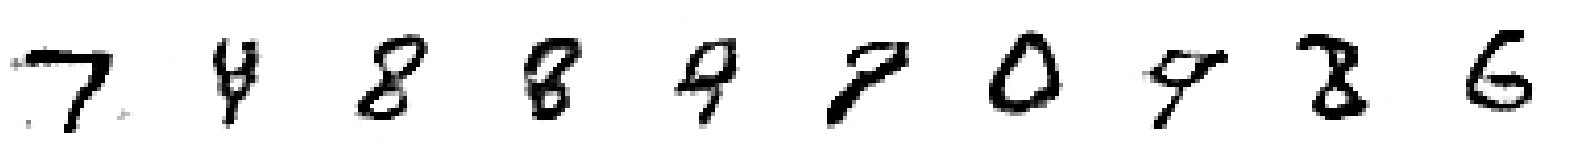


Saved to ./output/example_img_045.png


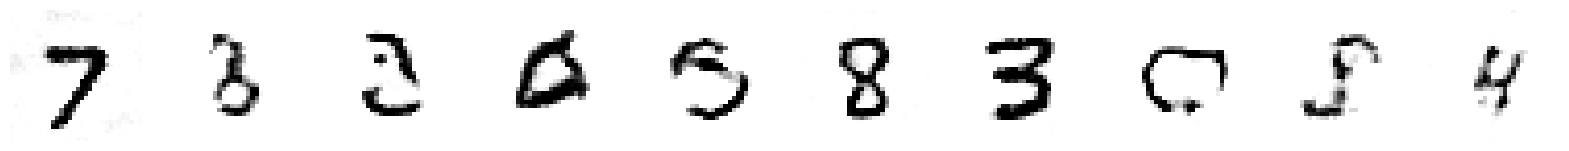

469/469 [==============================] - 420s 895ms/step - loss: 1.6997e-04 - reg: 1.3141e-04 - cdiv: 3.8562e-05 - real: 9.5931e-05 - fake: 1.3449e-04 - val_cdiv: -17.6774 - val_real: -0.0029 - val_fake: -17.6803
Epoch 47/60
469/469 [==============================] - ETA: 0s - loss: 1.1348e-04 - reg: 1.4085e-04 - cdiv: -2.7366e-05 - real: 4.5956e-04 - fake: 4.3220e-04     
Saved to ./output/generated_img_046.png


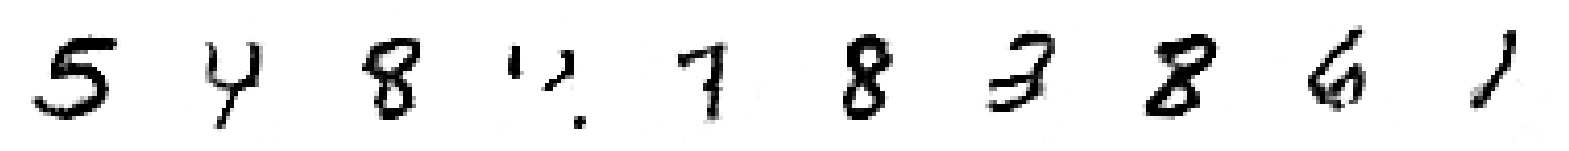


Saved to ./output/example_img_046.png


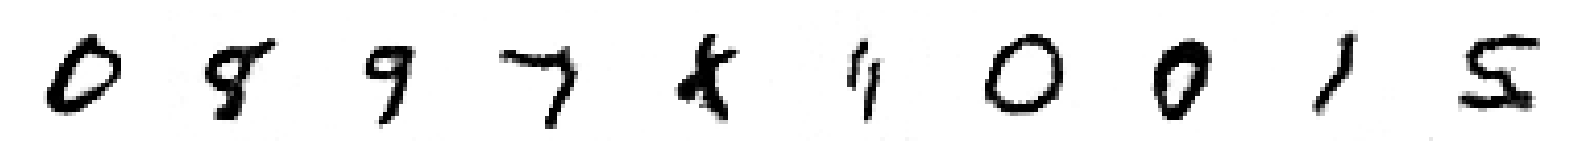

469/469 [==============================] - 413s 880ms/step - loss: 1.1348e-04 - reg: 1.4085e-04 - cdiv: -2.7366e-05 - real: 4.5956e-04 - fake: 4.3220e-04 - val_cdiv: -17.8088 - val_real: 7.0559e-04 - val_fake: -17.8081
Epoch 48/60
469/469 [==============================] - ETA: 0s - loss: 1.9055e-04 - reg: 1.5120e-04 - cdiv: 3.9347e-05 - real: 8.2218e-05 - fake: 1.2156e-04      
Saved to ./output/generated_img_047.png


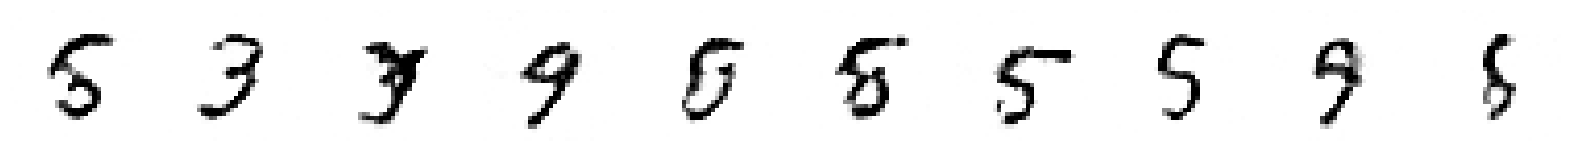


Saved to ./output/example_img_047.png


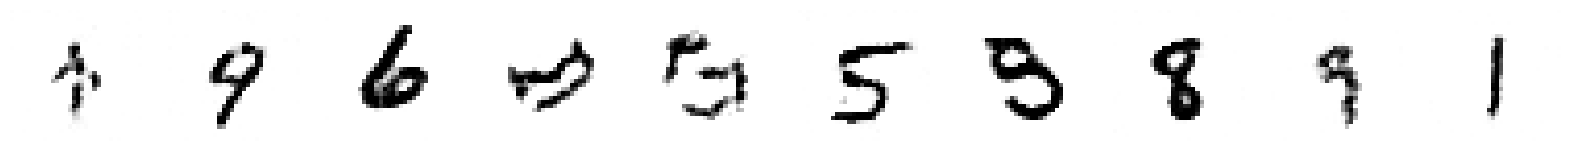

469/469 [==============================] - 413s 881ms/step - loss: 1.9055e-04 - reg: 1.5120e-04 - cdiv: 3.9347e-05 - real: 8.2218e-05 - fake: 1.2156e-04 - val_cdiv: -18.3009 - val_real: 0.0046 - val_fake: -18.2963
Epoch 49/60
469/469 [==============================] - ETA: 0s - loss: 1.6271e-04 - reg: 1.2118e-04 - cdiv: 4.1525e-05 - real: 1.3837e-04 - fake: 1.7990e-04      
Saved to ./output/generated_img_048.png


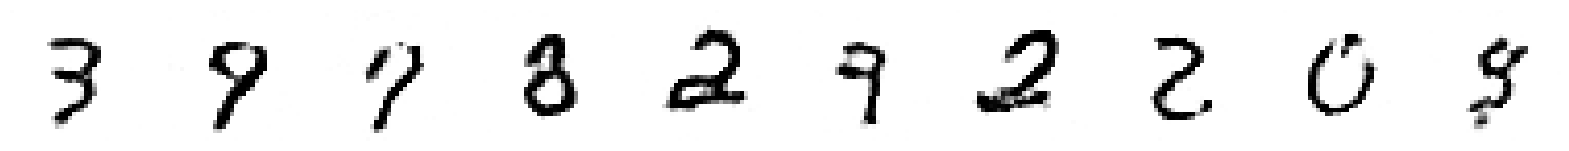


Saved to ./output/example_img_048.png


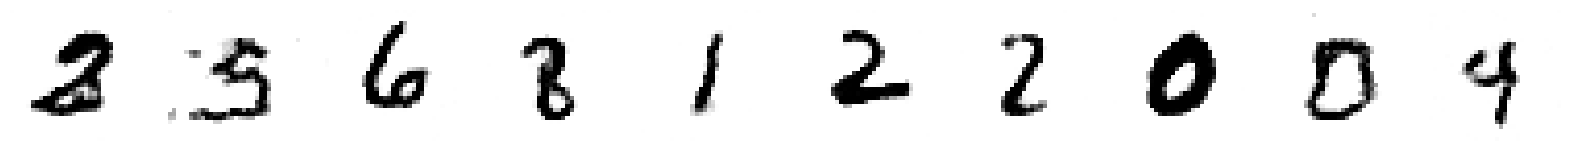

469/469 [==============================] - 413s 881ms/step - loss: 1.6271e-04 - reg: 1.2118e-04 - cdiv: 4.1525e-05 - real: 1.3837e-04 - fake: 1.7990e-04 - val_cdiv: -18.7717 - val_real: 0.0027 - val_fake: -18.7691
Epoch 50/60
469/469 [==============================] - ETA: 0s - loss: -2.6554e-05 - reg: 1.1576e-04 - cdiv: -1.4231e-04 - real: 3.1517e-04 - fake: 1.7286e-04    
Saved to ./output/generated_img_049.png


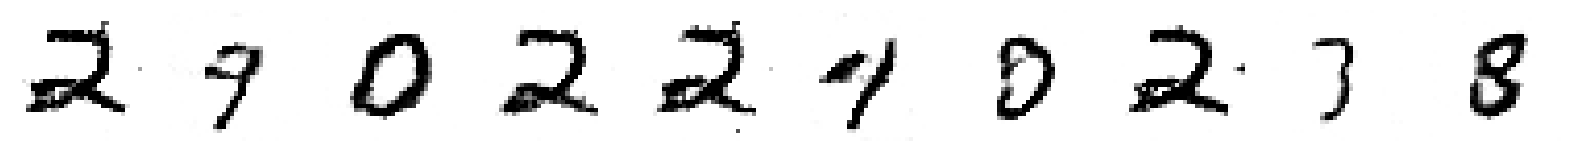


Saved to ./output/example_img_049.png


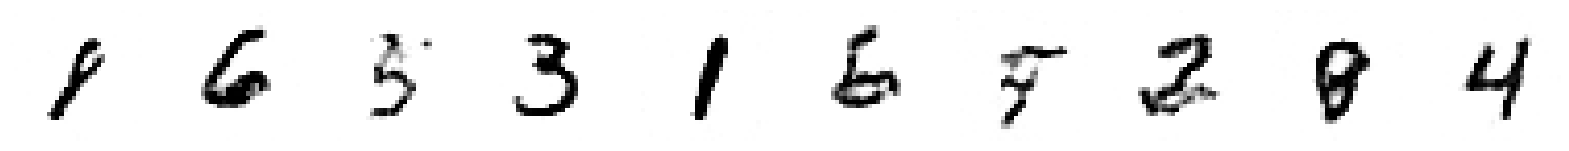

469/469 [==============================] - 416s 887ms/step - loss: -2.6554e-05 - reg: 1.1576e-04 - cdiv: -1.4231e-04 - real: 3.1517e-04 - fake: 1.7286e-04 - val_cdiv: -18.7688 - val_real: 0.0072 - val_fake: -18.7616
Epoch 51/60
469/469 [==============================] - ETA: 0s - loss: 1.3338e-04 - reg: 1.1034e-04 - cdiv: 2.3049e-05 - real: 4.2310e-04 - fake: 4.4615e-04    
Saved to ./output/generated_img_050.png


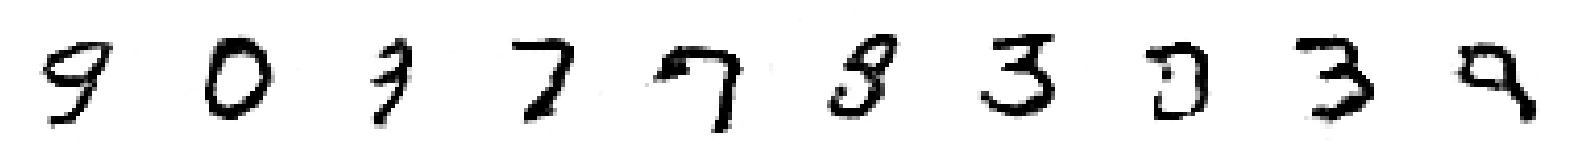


Saved to ./output/example_img_050.png


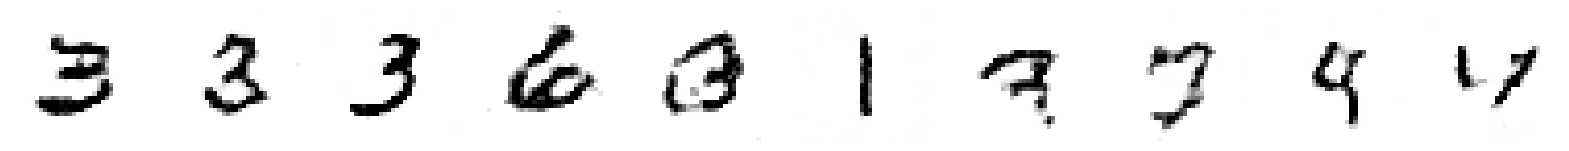

469/469 [==============================] - 415s 885ms/step - loss: 1.3338e-04 - reg: 1.1034e-04 - cdiv: 2.3049e-05 - real: 4.2310e-04 - fake: 4.4615e-04 - val_cdiv: -19.0198 - val_real: -0.0020 - val_fake: -19.0219
Epoch 52/60
469/469 [==============================] - ETA: 0s - loss: 8.3445e-05 - reg: 1.0236e-04 - cdiv: -1.8913e-05 - real: 2.0019e-04 - fake: 1.8128e-04     
Saved to ./output/generated_img_051.png


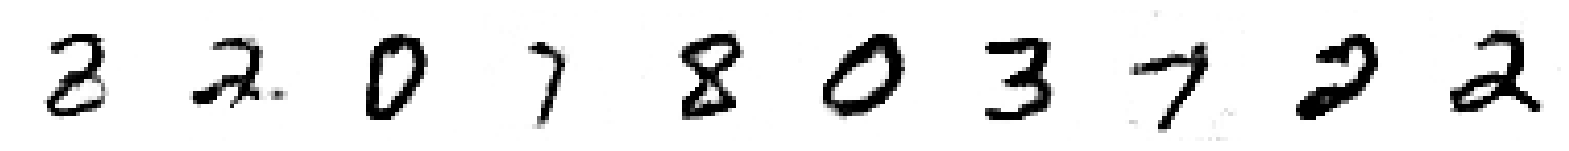


Saved to ./output/example_img_051.png


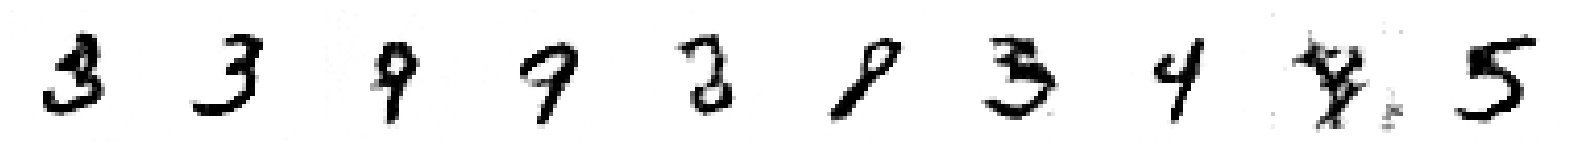

469/469 [==============================] - 414s 882ms/step - loss: 8.3445e-05 - reg: 1.0236e-04 - cdiv: -1.8913e-05 - real: 2.0019e-04 - fake: 1.8128e-04 - val_cdiv: -19.3477 - val_real: 0.0054 - val_fake: -19.3423
Epoch 53/60
469/469 [==============================] - ETA: 0s - loss: -5.3450e-05 - reg: 1.7787e-04 - cdiv: -2.3132e-04 - real: 1.3096e-04 - fake: -1.0035e-04   
Saved to ./output/generated_img_052.png


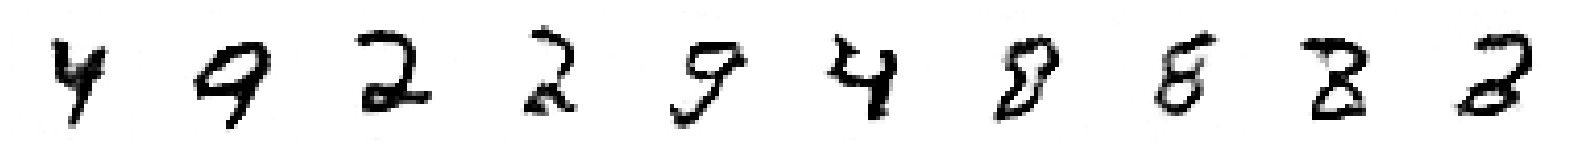


Saved to ./output/example_img_052.png


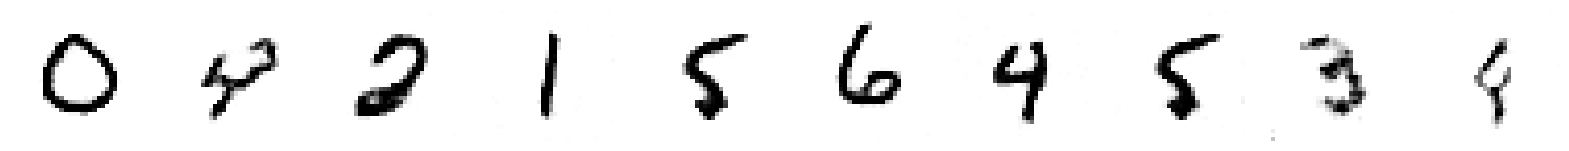

469/469 [==============================] - 414s 882ms/step - loss: -5.3450e-05 - reg: 1.7787e-04 - cdiv: -2.3132e-04 - real: 1.3096e-04 - fake: -1.0035e-04 - val_cdiv: -20.0625 - val_real: 0.0036 - val_fake: -20.0589
Epoch 54/60
469/469 [==============================] - ETA: 0s - loss: 7.6832e-05 - reg: 1.2806e-04 - cdiv: -5.1230e-05 - real: 6.9167e-04 - fake: 6.4044e-04     
Saved to ./output/generated_img_053.png


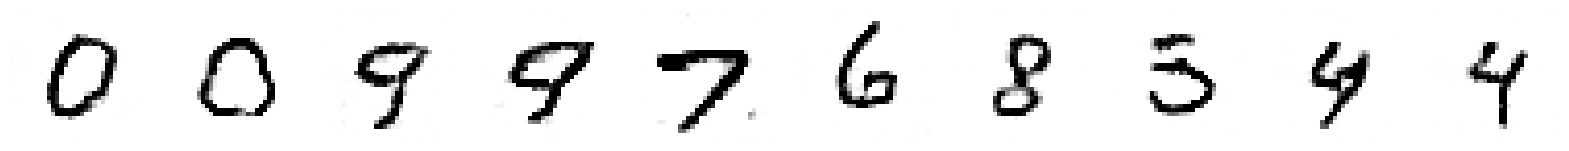


Saved to ./output/example_img_053.png


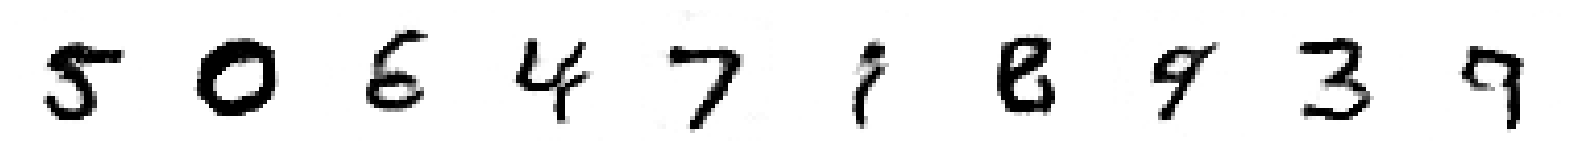

469/469 [==============================] - 418s 892ms/step - loss: 7.6832e-05 - reg: 1.2806e-04 - cdiv: -5.1230e-05 - real: 6.9167e-04 - fake: 6.4044e-04 - val_cdiv: -19.9619 - val_real: 8.3121e-04 - val_fake: -19.9611
Epoch 55/60
469/469 [==============================] - ETA: 0s - loss: 1.8475e-04 - reg: 1.2205e-04 - cdiv: 6.2703e-05 - real: -5.5231e-05 - fake: 7.4719e-06     
Saved to ./output/generated_img_054.png


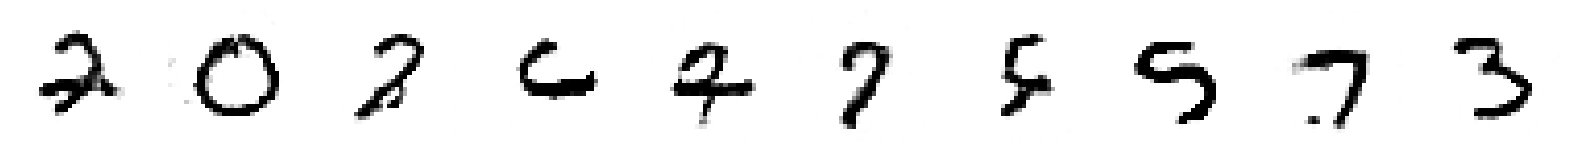


Saved to ./output/example_img_054.png


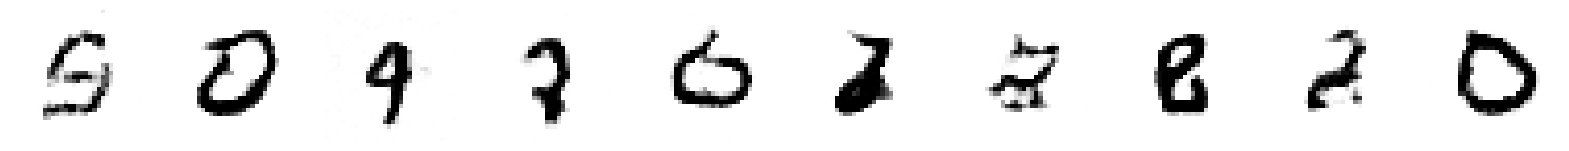

469/469 [==============================] - 418s 892ms/step - loss: 1.8475e-04 - reg: 1.2205e-04 - cdiv: 6.2703e-05 - real: -5.5231e-05 - fake: 7.4719e-06 - val_cdiv: -20.4265 - val_real: -0.0037 - val_fake: -20.4301
Epoch 56/60
469/469 [==============================] - ETA: 0s - loss: 1.1359e-04 - reg: 1.4335e-04 - cdiv: -2.9750e-05 - real: 3.4056e-04 - fake: 3.1081e-04     
Saved to ./output/generated_img_055.png


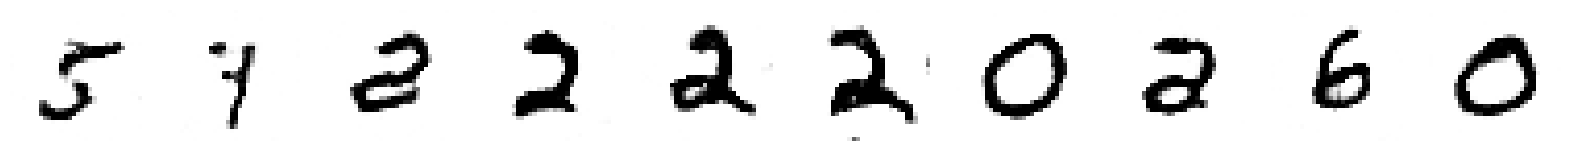


Saved to ./output/example_img_055.png


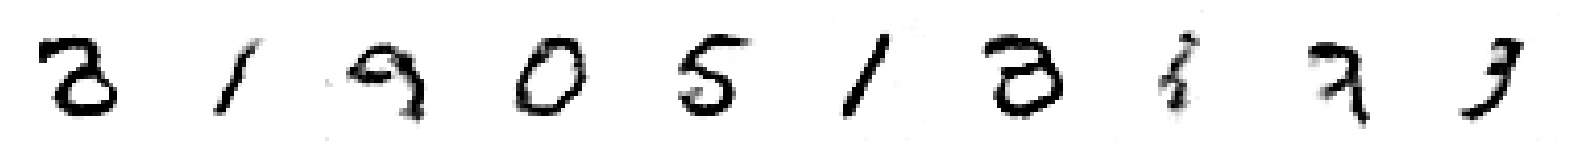

469/469 [==============================] - 416s 888ms/step - loss: 1.1359e-04 - reg: 1.4335e-04 - cdiv: -2.9750e-05 - real: 3.4056e-04 - fake: 3.1081e-04 - val_cdiv: -19.9816 - val_real: -0.0064 - val_fake: -19.9879
Epoch 57/60
469/469 [==============================] - ETA: 0s - loss: 6.4681e-05 - reg: 1.4442e-04 - cdiv: -7.9735e-05 - real: 2.6287e-04 - fake: 1.8313e-04     
Saved to ./output/generated_img_056.png


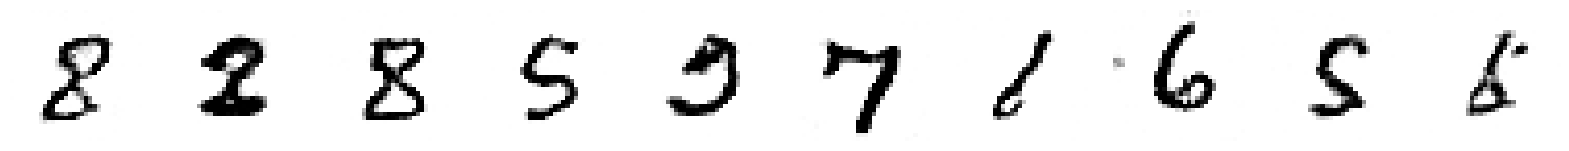


Saved to ./output/example_img_056.png


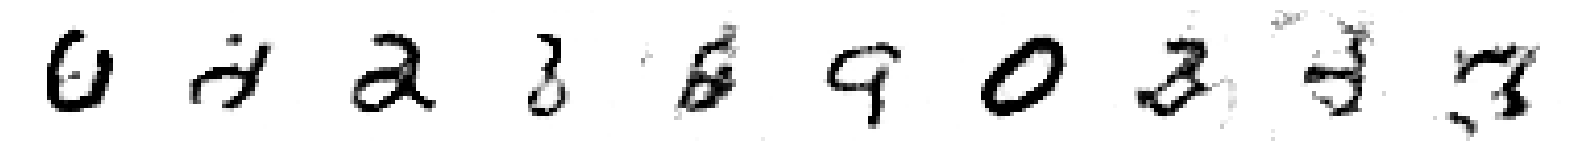

469/469 [==============================] - 416s 887ms/step - loss: 6.4681e-05 - reg: 1.4442e-04 - cdiv: -7.9735e-05 - real: 2.6287e-04 - fake: 1.8313e-04 - val_cdiv: -20.0433 - val_real: 1.8740e-04 - val_fake: -20.0431
Epoch 58/60
469/469 [==============================] - ETA: 0s - loss: 2.6948e-04 - reg: 1.3465e-04 - cdiv: 1.3483e-04 - real: 1.8338e-04 - fake: 3.1822e-04      
Saved to ./output/generated_img_057.png


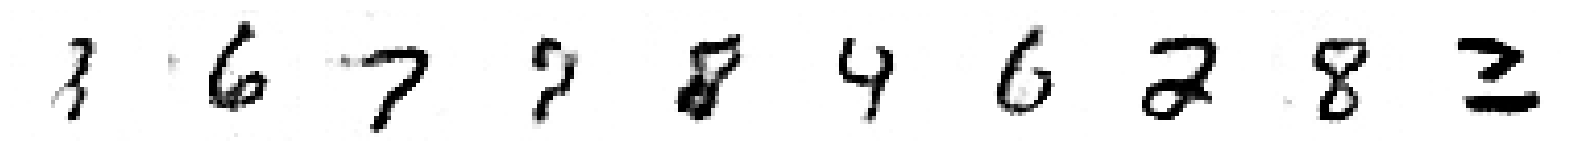


Saved to ./output/example_img_057.png


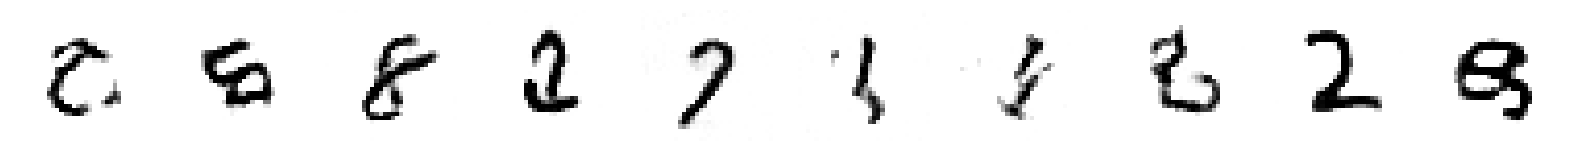

469/469 [==============================] - 414s 883ms/step - loss: 2.6948e-04 - reg: 1.3465e-04 - cdiv: 1.3483e-04 - real: 1.8338e-04 - fake: 3.1822e-04 - val_cdiv: -20.3219 - val_real: 4.2753e-04 - val_fake: -20.3214
Epoch 59/60
469/469 [==============================] - ETA: 0s - loss: 8.7567e-05 - reg: 1.2143e-04 - cdiv: -3.3867e-05 - real: -7.2484e-05 - fake: -1.0635e-04   
Saved to ./output/generated_img_058.png


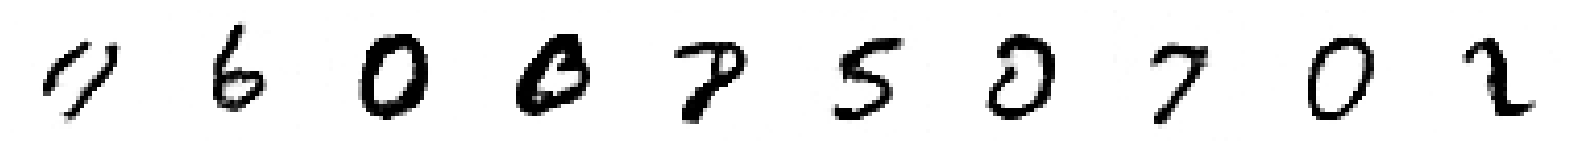


Saved to ./output/example_img_058.png


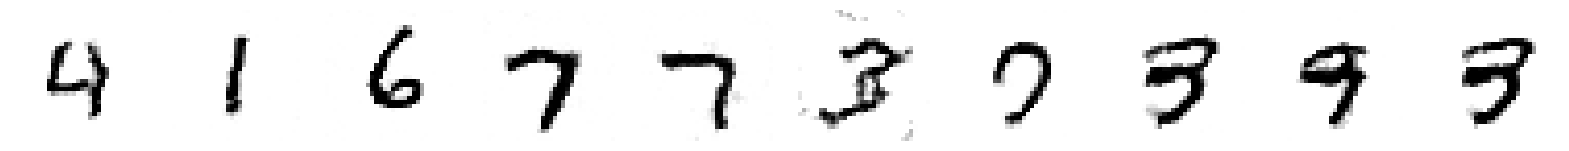

469/469 [==============================] - 415s 885ms/step - loss: 8.7567e-05 - reg: 1.2143e-04 - cdiv: -3.3867e-05 - real: -7.2484e-05 - fake: -1.0635e-04 - val_cdiv: -20.3618 - val_real: -0.0022 - val_fake: -20.3640
Epoch 60/60
469/469 [==============================] - ETA: 0s - loss: 5.6752e-05 - reg: 1.5560e-04 - cdiv: -9.8848e-05 - real: 3.9865e-04 - fake: 2.9981e-04     
Saved to ./output/generated_img_059.png


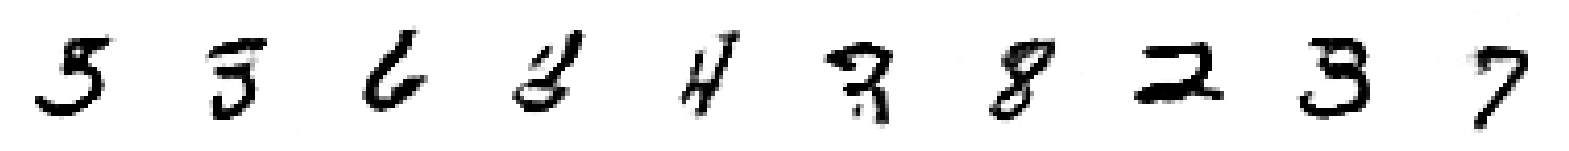


Saved to ./output/example_img_059.png


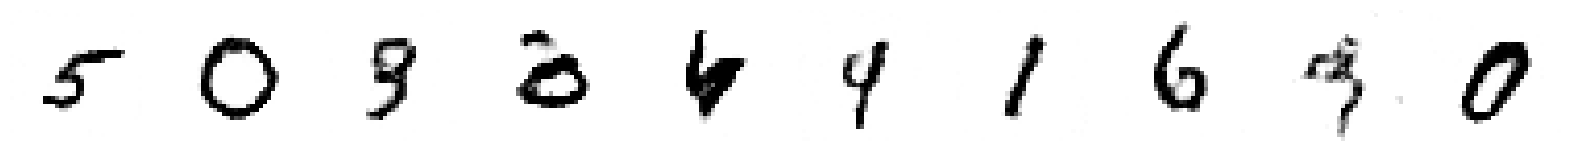

469/469 [==============================] - 415s 886ms/step - loss: 5.6752e-05 - reg: 1.5560e-04 - cdiv: -9.8848e-05 - real: 3.9865e-04 - fake: 2.9981e-04 - val_cdiv: -19.6791 - val_real: -0.0104 - val_fake: -19.6895


In [16]:
ebm.fit(
    x_train,
    shuffle=True,
    epochs=60,
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

## 4. Generate images <a name="generate"></a>

In [17]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)

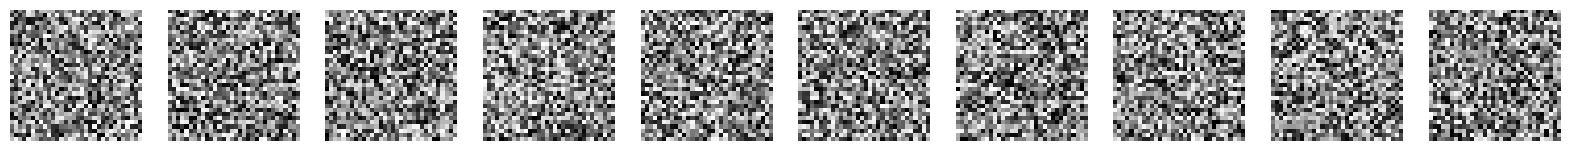

In [18]:
display(start_imgs)

In [19]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

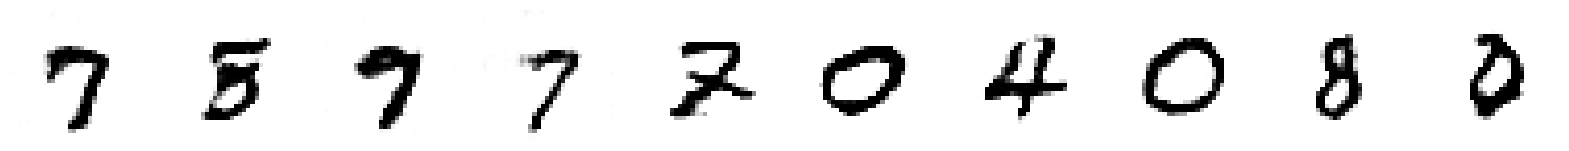

In [20]:
display(gen_img[-1].numpy())

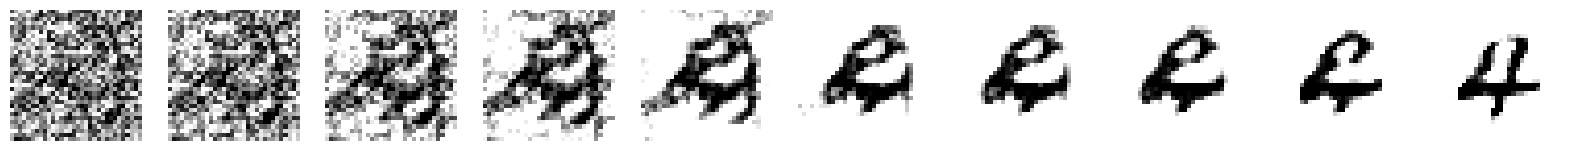

In [21]:
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])

display(np.array(imgs))